In [1]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot
    
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# Convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for temperature
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for temperature
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for temperature
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    #print("Agg:")
    agg.columns = names
    #print(type(agg))
    #print(agg)

    #print("Test columns:")
    #print(agg.iloc[:, -37]) # Column containing response actual values (temperature) at time t-3
    #print(agg.iloc[:, -25]) # Column containing response actual values (temperature) at time t-2
    #print(agg.iloc[:, -13]) # Column containing response actual values (temperature) at time t-1
    #print(agg.iloc[:, -1]) # Column containing response actual values (temperature) at time t
    
    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 27 time steps (the first 23 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 26-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 23 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    #diff_values_training = np.array(diff_values_for_training)
    #diff_values_training = diff_values_training.reshape(1, -1) 
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (temperatures) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    #print("Scaled values rows:")
    #print(len(scaled_values))

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    # Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    
    
    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 2:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 1
if n_seq > 3:
    n_lag = 25 - n_seq
else:
    n_lag = 22
n_time_steps = 27
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([5, 9, 21, 22, 41, 42, 45, 46, 52, 66, 68, 72, 79, 81, 82, 83, 90, 92, 95])
test_array.append([4, 10, 47, 53, 94])
    
train_array.append([4, 9, 10, 21, 41, 45, 46, 47, 52, 53, 66, 68, 81, 82, 83, 90, 92, 94, 95])
test_array.append([5, 22, 42, 72, 79])
    
train_array.append([4, 5, 10, 21, 22, 41, 42, 46, 47, 52, 53, 72, 79, 82, 83, 90, 92, 94, 95])
test_array.append([9, 45, 66, 68, 81])
    
train_array.append([4, 5, 9, 10, 21, 22, 42, 45, 47, 52, 53, 66, 68, 72, 79, 81, 82, 92, 94, 95])
test_array.append([41, 46, 83, 90])
    
train_array.append([4, 5, 9, 10, 22, 41, 42, 45, 46, 47, 53, 66, 68, 72, 79, 81, 83, 90, 94])
test_array.append([21, 52, 82, 92, 95])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Yearly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'date', 'latitude', 'longitude', 'elevation'], axis=1)

#Test model and accuracy when solar activity is removed as a predictor
df_trimmed = df_trimmed.drop(['ONI'], axis=1)

n_vars = df_trimmed.shape[1]-1

X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['temperatures'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['temperatures'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)

print(df_trimmed)
print(new_df)
print(X[0])

#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of the train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of the validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
    #print("Train_X Fold "+str(i)+":")
    #print(len(train_X[i]))
    #print(len(train_X[i][0]))
    #print(len(train_X[i][0][0])) 
    #print("Train_y Fold "+str(i)+":")
    #print(len(train_y[i]))
    #print(len(train_y[i][0]))
    #print(train_y[i][0][0])
    #print("Validation_X Fold "+str(i)+":")
    #print(len(val_X[i]))
    #print(len(val_X[i][0]))
    #print(len(val_X[i][0][0]))
    #print("Validation_y Fold "+str(i)+":")
    #print(len(val_y[i]))
    #print(len(val_y[i][0]))
    #print(val_y[i][0][0])
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    if i==3:
        train_size = 20
        val_size = 4
    else:
        train_size = 19
        val_size = 5
        
    for k in range(train_size):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)
     

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(train_size):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['temperatures']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(val_size):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(val_size):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['temperatures']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(train_size):
        train2.append(train1[k][0])
        
    for k in range(2):
        test2.append(test1[k][0])

    for k in range(val_size-2):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + n_vars*n_lag
    train1 = np.array(train[i]).reshape(train_size, dim_size)
    test1 = np.array(test[i]).reshape(2, dim_size)
    validation1 = np.array(validation[i]).reshape(val_size-2, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]

print("Finished")

Model Parameters:
n_lag (number of input time steps): 22
n_seq (number of output/future prediction time steps): 1
C:\Users\User
C:\Users\User\Modeling\
     file_id  temperatures      slp  wet_bulb_temperature  specific_humidity  \
0       6678         20.84  1016.20                 18.08              12.82   
1       6678         20.69  1017.48                 17.71              12.33   
2       6678         20.47  1018.26                 17.29              12.14   
3       6678         20.30  1018.41                 17.20              11.90   
4       6678         20.46  1017.92                 17.75              12.75   
..       ...           ...      ...                   ...                ...   
643     8000         13.02  1016.94                  7.64               5.15   
644     8000         13.47  1016.16                  7.88               5.24   
645     8000         11.84  1017.90                  7.13               5.36   
646     8000         12.86  1016.17             

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

1
22
(19, 243)
(2, 243)


[I 2025-06-04 21:59:03,416] A new study created in memory with name: no-name-60a8fe6f-7dd2-4bb1-8cea-f00efc754df6
[I 2025-06-04 22:02:16,209] Trial 0 finished with value: 0.3508098632097244 and parameters: {'lr': 0.014924907976763135, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.22968474613185405}. Best is trial 0 with value: 0.3508098632097244.


Cross Validation Accuracies:
[0.31694847345352173, 0.24358566105365753, 0.4086708426475525, 0.39409443736076355, 0.39074990153312683]
Mean Cross Validation Accuracy:
0.3508098632097244
Standard Deviation of Cross Validation Accuracy:
0.062386340181874736


[I 2025-06-04 22:04:00,023] Trial 1 finished with value: 0.09139148220419883 and parameters: {'lr': 0.11819460802548723, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.15316215259857616}. Best is trial 1 with value: 0.09139148220419883.


Cross Validation Accuracies:
[0.03133263811469078, 0.18929797410964966, 0.07017818838357925, 0.07895904034376144, 0.08718957006931305]
Mean Cross Validation Accuracy:
0.09139148220419883
Standard Deviation of Cross Validation Accuracy:
0.05256419203511519


[I 2025-06-04 22:05:36,507] Trial 2 finished with value: 0.3678994581103325 and parameters: {'lr': 0.014422730018897222, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.2509813795754883}. Best is trial 1 with value: 0.09139148220419883.


Cross Validation Accuracies:
[0.1154717430472374, 0.5204821825027466, 0.42191892862319946, 0.39664873480796814, 0.38497570157051086]
Mean Cross Validation Accuracy:
0.3678994581103325
Standard Deviation of Cross Validation Accuracy:
0.13493514094617867


[I 2025-06-04 22:07:31,545] Trial 3 finished with value: 0.1180553339421749 and parameters: {'lr': 0.0030943748204412245, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.3032264616437002}. Best is trial 1 with value: 0.09139148220419883.


Cross Validation Accuracies:
[0.041648659855127335, 0.12029258161783218, 0.11548484861850739, 0.15779909491539001, 0.15505148470401764]
Mean Cross Validation Accuracy:
0.1180553339421749
Standard Deviation of Cross Validation Accuracy:
0.041947286502215575


[I 2025-06-04 22:09:34,464] Trial 4 finished with value: 0.14735047519207 and parameters: {'lr': 0.001895244977037505, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.2832334391324457}. Best is trial 1 with value: 0.09139148220419883.


Cross Validation Accuracies:
[0.0891132801771164, 0.3616834282875061, 0.07362498342990875, 0.050230205059051514, 0.16210047900676727]
Mean Cross Validation Accuracy:
0.14735047519207
Standard Deviation of Cross Validation Accuracy:
0.11350378256660588


[I 2025-06-04 22:11:11,365] Trial 5 finished with value: 0.4282930433750153 and parameters: {'lr': 0.9207777954237267, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.20921769024480927}. Best is trial 1 with value: 0.09139148220419883.


Cross Validation Accuracies:
[0.3910066783428192, 0.36008185148239136, 0.4696389138698578, 0.47354012727737427, 0.44719764590263367]
Mean Cross Validation Accuracy:
0.4282930433750153
Standard Deviation of Cross Validation Accuracy:
0.04507150612548281


[I 2025-06-04 22:12:48,000] Trial 6 finished with value: 0.30099728107452395 and parameters: {'lr': 0.0265277572771679, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.4181832258944319}. Best is trial 1 with value: 0.09139148220419883.


Cross Validation Accuracies:
[0.5663537979125977, 0.26192232966423035, 0.23036335408687592, 0.1998705416917801, 0.24647638201713562]
Mean Cross Validation Accuracy:
0.30099728107452395
Standard Deviation of Cross Validation Accuracy:
0.13426036671338226


[I 2025-06-04 22:14:21,330] Trial 7 finished with value: 0.06800308525562286 and parameters: {'lr': 0.001013327760321767, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.4835529875389717}. Best is trial 7 with value: 0.06800308525562286.


Cross Validation Accuracies:
[0.07722607254981995, 0.12899738550186157, 0.01818133518099785, 0.043267685920000076, 0.07234294712543488]
Mean Cross Validation Accuracy:
0.06800308525562286
Standard Deviation of Cross Validation Accuracy:
0.0371974443181179


[I 2025-06-04 22:16:06,436] Trial 8 finished with value: 2.439510536193848 and parameters: {'lr': 0.051045345366332685, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.28893955183719694}. Best is trial 7 with value: 0.06800308525562286.


Cross Validation Accuracies:
[2.488136053085327, 2.288771867752075, 2.579575538635254, 2.412841796875, 2.428227424621582]
Mean Cross Validation Accuracy:
2.439510536193848
Standard Deviation of Cross Validation Accuracy:
0.0954393233725828


[I 2025-06-04 22:18:07,237] Trial 9 finished with value: 0.09288732893764973 and parameters: {'lr': 0.08715575632523646, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.14488733800405212}. Best is trial 7 with value: 0.06800308525562286.


Cross Validation Accuracies:
[0.027785049751400948, 0.18536069989204407, 0.07889383286237717, 0.08723863214254379, 0.08515843003988266]
Mean Cross Validation Accuracy:
0.09288732893764973
Standard Deviation of Cross Validation Accuracy:
0.05114116282795478


[I 2025-06-04 22:19:54,717] Trial 10 finished with value: 0.11236803233623505 and parameters: {'lr': 0.0013021791511689952, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.4973187605946034}. Best is trial 7 with value: 0.06800308525562286.


Cross Validation Accuracies:
[0.038547758013010025, 0.23968373239040375, 0.09554959833621979, 0.1276000291109085, 0.06045904383063316]
Mean Cross Validation Accuracy:
0.11236803233623505
Standard Deviation of Cross Validation Accuracy:
0.07052394900609366


[I 2025-06-04 22:21:30,459] Trial 11 finished with value: 0.07779085114598275 and parameters: {'lr': 0.2298290639853699, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.11064213142273119}. Best is trial 7 with value: 0.06800308525562286.


Cross Validation Accuracies:
[0.03593818098306656, 0.03778255358338356, 0.10670121759176254, 0.10869083553552628, 0.09984146803617477]
Mean Cross Validation Accuracy:
0.07779085114598275
Standard Deviation of Cross Validation Accuracy:
0.03355341384170815


[I 2025-06-04 22:23:05,816] Trial 12 finished with value: 37.31374549865723 and parameters: {'lr': 0.5099337121893853, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.3810319647870563}. Best is trial 7 with value: 0.06800308525562286.


Cross Validation Accuracies:
[34.322715759277344, 52.33551788330078, 53.0694580078125, 19.102392196655273, 27.738643646240234]
Mean Cross Validation Accuracy:
37.31374549865723
Standard Deviation of Cross Validation Accuracy:
13.462379772711385


[I 2025-06-04 22:24:39,442] Trial 13 finished with value: 0.279737651348114 and parameters: {'lr': 0.2812440250353332, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.4969131699094117}. Best is trial 7 with value: 0.06800308525562286.


Cross Validation Accuracies:
[0.17386996746063232, 0.348499596118927, 0.3489069640636444, 0.2322874665260315, 0.29512426257133484]
Mean Cross Validation Accuracy:
0.279737651348114
Standard Deviation of Cross Validation Accuracy:
0.0681305118232459


[I 2025-06-04 22:26:13,784] Trial 14 finished with value: 0.07563994340598583 and parameters: {'lr': 0.005519227407855365, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.10474417274325143}. Best is trial 7 with value: 0.06800308525562286.


Cross Validation Accuracies:
[0.1356523036956787, 0.10509536415338516, 0.017769908532500267, 0.06708822399377823, 0.05259391665458679]
Mean Cross Validation Accuracy:
0.07563994340598583
Standard Deviation of Cross Validation Accuracy:
0.04104216707030952


[I 2025-06-04 22:27:54,775] Trial 15 finished with value: 0.09469137862324714 and parameters: {'lr': 0.005724162770634843, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.3712136499451135}. Best is trial 7 with value: 0.06800308525562286.


Cross Validation Accuracies:
[0.11861700564622879, 0.16965541243553162, 0.03558891639113426, 0.050949275493621826, 0.09864628314971924]
Mean Cross Validation Accuracy:
0.09469137862324714
Standard Deviation of Cross Validation Accuracy:
0.048195758924965124


[I 2025-06-04 22:29:53,406] Trial 16 finished with value: 0.06656415946781635 and parameters: {'lr': 0.005145138956052806, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.4387178215009715}. Best is trial 16 with value: 0.06656415946781635.


Cross Validation Accuracies:
[0.08027070760726929, 0.12110759317874908, 0.02631678618490696, 0.03843412548303604, 0.06669158488512039]
Mean Cross Validation Accuracy:
0.06656415946781635
Standard Deviation of Cross Validation Accuracy:
0.03338868589290023


[I 2025-06-04 22:32:07,443] Trial 17 finished with value: 0.10488977134227753 and parameters: {'lr': 0.003635507863918699, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.4466460921133026}. Best is trial 16 with value: 0.06656415946781635.


Cross Validation Accuracies:
[0.132937490940094, 0.10560513287782669, 0.032217592000961304, 0.17784616351127625, 0.0758424773812294]
Mean Cross Validation Accuracy:
0.10488977134227753
Standard Deviation of Cross Validation Accuracy:
0.04946678160494574


[I 2025-06-04 22:34:17,022] Trial 18 finished with value: 0.12900003157556056 and parameters: {'lr': 0.0013819955704951533, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.44671021393315047}. Best is trial 16 with value: 0.06656415946781635.


Cross Validation Accuracies:
[0.030255375429987907, 0.08105172961950302, 0.246741384267807, 0.111723892390728, 0.17522777616977692]
Mean Cross Validation Accuracy:
0.12900003157556056
Standard Deviation of Cross Validation Accuracy:
0.07529680241149478


[I 2025-06-04 22:36:35,582] Trial 19 finished with value: 0.06343299262225628 and parameters: {'lr': 0.010000315675331878, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.34970919536701617}. Best is trial 19 with value: 0.06343299262225628.


Cross Validation Accuracies:
[0.07288169115781784, 0.12703102827072144, 0.022842710837721825, 0.040443055331707, 0.05396647751331329]
Mean Cross Validation Accuracy:
0.06343299262225628
Standard Deviation of Cross Validation Accuracy:
0.035776280250016244


[I 2025-06-04 22:38:47,881] Trial 20 finished with value: 0.09129155464470387 and parameters: {'lr': 0.010685928952627136, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.345728785116331}. Best is trial 19 with value: 0.06343299262225628.


Cross Validation Accuracies:
[0.10141696780920029, 0.09787123650312424, 0.029322577640414238, 0.04191238805651665, 0.18593460321426392]
Mean Cross Validation Accuracy:
0.09129155464470387
Standard Deviation of Cross Validation Accuracy:
0.055464545525140664


[I 2025-06-04 22:40:46,502] Trial 21 finished with value: 0.07001978605985641 and parameters: {'lr': 0.007765468991168242, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.422010776457812}. Best is trial 19 with value: 0.06343299262225628.


Cross Validation Accuracies:
[0.08571042865514755, 0.09895973652601242, 0.04957353696227074, 0.04731583222746849, 0.06853939592838287]
Mean Cross Validation Accuracy:
0.07001978605985641
Standard Deviation of Cross Validation Accuracy:
0.020096901128093442


[I 2025-06-04 22:43:13,646] Trial 22 finished with value: 0.0670644260942936 and parameters: {'lr': 0.0025851276258510524, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.4619901452304911}. Best is trial 19 with value: 0.06343299262225628.


Cross Validation Accuracies:
[0.09105167537927628, 0.10413443297147751, 0.02068784087896347, 0.051737699657678604, 0.06771048158407211]
Mean Cross Validation Accuracy:
0.0670644260942936
Standard Deviation of Cross Validation Accuracy:
0.02944719723616442


[I 2025-06-04 22:44:48,091] Trial 23 finished with value: 0.06493663340806961 and parameters: {'lr': 0.002774436400089053, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.34108873866478806}. Best is trial 19 with value: 0.06343299262225628.


Cross Validation Accuracies:
[0.08685428649187088, 0.1203388050198555, 0.022682972252368927, 0.039248835295438766, 0.05555826798081398]
Mean Cross Validation Accuracy:
0.06493663340806961
Standard Deviation of Cross Validation Accuracy:
0.03487971538595701


[I 2025-06-04 22:46:22,056] Trial 24 finished with value: 0.06825585663318634 and parameters: {'lr': 0.02610553343574487, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.35396250332956186}. Best is trial 19 with value: 0.06343299262225628.


Cross Validation Accuracies:
[0.07063683122396469, 0.09671054035425186, 0.07441367954015732, 0.04517136514186859, 0.05434686690568924]
Mean Cross Validation Accuracy:
0.06825585663318634
Standard Deviation of Cross Validation Accuracy:
0.017774198104408317


[I 2025-06-04 22:47:57,355] Trial 25 finished with value: 0.06612173840403557 and parameters: {'lr': 0.004205781634556292, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.32009659470598967}. Best is trial 19 with value: 0.06343299262225628.


Cross Validation Accuracies:
[0.08194795250892639, 0.11666160076856613, 0.017859168350696564, 0.04489557817578316, 0.0692443922162056]
Mean Cross Validation Accuracy:
0.06612173840403557
Standard Deviation of Cross Validation Accuracy:
0.03344943423658791


[I 2025-06-04 22:49:31,450] Trial 26 finished with value: 0.07566380277276039 and parameters: {'lr': 0.009553056189876908, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3238429393867928}. Best is trial 19 with value: 0.06343299262225628.


Cross Validation Accuracies:
[0.11019320785999298, 0.15001879632472992, 0.018942419439554214, 0.0421108715236187, 0.05705371871590614]
Mean Cross Validation Accuracy:
0.07566380277276039
Standard Deviation of Cross Validation Accuracy:
0.04777110974854355


[I 2025-06-04 22:51:06,130] Trial 27 finished with value: 0.07371043078601361 and parameters: {'lr': 0.0025214829899310775, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.39450412300791027}. Best is trial 19 with value: 0.06343299262225628.


Cross Validation Accuracies:
[0.10247621685266495, 0.13025012612342834, 0.01821260340511799, 0.04540826752781868, 0.07220494002103806]
Mean Cross Validation Accuracy:
0.07371043078601361
Standard Deviation of Cross Validation Accuracy:
0.0397680660541009


[I 2025-06-04 22:52:47,576] Trial 28 finished with value: 0.12159694731235504 and parameters: {'lr': 0.01875513240912017, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.33671916891530607}. Best is trial 19 with value: 0.06343299262225628.


Cross Validation Accuracies:
[0.04094545170664787, 0.1590091586112976, 0.2959004342556, 0.03858814015984535, 0.0735415518283844]
Mean Cross Validation Accuracy:
0.12159694731235504
Standard Deviation of Cross Validation Accuracy:
0.09745340010311745


[I 2025-06-04 22:54:21,602] Trial 29 finished with value: 0.07809356674551964 and parameters: {'lr': 0.039291922536018875, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.23892948764701497}. Best is trial 19 with value: 0.06343299262225628.


Cross Validation Accuracies:
[0.10181532800197601, 0.13833516836166382, 0.05539471656084061, 0.039343371987342834, 0.05557924881577492]
Mean Cross Validation Accuracy:
0.07809356674551964
Standard Deviation of Cross Validation Accuracy:
0.03664828079932618


[I 2025-06-04 22:56:30,440] Trial 30 finished with value: 0.14113876968622208 and parameters: {'lr': 0.004261029435680337, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.26241264960539923}. Best is trial 19 with value: 0.06343299262225628.


Cross Validation Accuracies:
[0.12185602635145187, 0.08408063650131226, 0.1690434217453003, 0.15860743820667267, 0.1721063256263733]
Mean Cross Validation Accuracy:
0.14113876968622208
Standard Deviation of Cross Validation Accuracy:
0.03367571308935722


[I 2025-06-04 22:58:14,139] Trial 31 finished with value: 0.07406913414597512 and parameters: {'lr': 0.007381738891094286, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.3171905813710246}. Best is trial 19 with value: 0.06343299262225628.


Cross Validation Accuracies:
[0.10053493827581406, 0.13486865162849426, 0.03670145198702812, 0.04332675412297249, 0.054913874715566635]
Mean Cross Validation Accuracy:
0.07406913414597512
Standard Deviation of Cross Validation Accuracy:
0.037697166147081136


[I 2025-06-04 22:59:51,684] Trial 32 finished with value: 0.08221308588981628 and parameters: {'lr': 0.004673939949070427, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.40492909829999546}. Best is trial 19 with value: 0.06343299262225628.


Cross Validation Accuracies:
[0.11968067288398743, 0.1598012000322342, 0.017756175249814987, 0.03932017460465431, 0.0745072066783905]
Mean Cross Validation Accuracy:
0.08221308588981628
Standard Deviation of Cross Validation Accuracy:
0.05191841922388166


[I 2025-06-04 23:01:34,962] Trial 33 finished with value: 0.07288309670984745 and parameters: {'lr': 0.014085454442039175, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.36643516692148}. Best is trial 19 with value: 0.06343299262225628.


Cross Validation Accuracies:
[0.07405199855566025, 0.1591801643371582, 0.017839575186371803, 0.043739669024944305, 0.06960407644510269]
Mean Cross Validation Accuracy:
0.07288309670984745
Standard Deviation of Cross Validation Accuracy:
0.04762022852827337


[I 2025-06-04 23:03:17,027] Trial 34 finished with value: 0.06736326329410076 and parameters: {'lr': 0.0017833865460412336, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.20594671073763984}. Best is trial 19 with value: 0.06343299262225628.


Cross Validation Accuracies:
[0.09050805866718292, 0.12423072010278702, 0.019192615523934364, 0.047168973833322525, 0.05571594834327698]
Mean Cross Validation Accuracy:
0.06736326329410076
Standard Deviation of Cross Validation Accuracy:
0.03642381027771933


[I 2025-06-04 23:05:20,906] Trial 35 finished with value: 0.14871610328555107 and parameters: {'lr': 0.013688902319548875, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.2762776298734826}. Best is trial 19 with value: 0.06343299262225628.


Cross Validation Accuracies:
[0.0550212636590004, 0.24445322155952454, 0.22407685220241547, 0.15792207419872284, 0.06210710480809212]
Mean Cross Validation Accuracy:
0.14871610328555107
Standard Deviation of Cross Validation Accuracy:
0.07900560712137229


[I 2025-06-04 23:06:29,370] Trial 36 finished with value: 0.06497123129665852 and parameters: {'lr': 0.002554162251405151, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3035730237289742}. Best is trial 19 with value: 0.06343299262225628.


Cross Validation Accuracies:
[0.06860780715942383, 0.12669354677200317, 0.017898784950375557, 0.03828727453947067, 0.07336874306201935]
Mean Cross Validation Accuracy:
0.06497123129665852
Standard Deviation of Cross Validation Accuracy:
0.036935716775869265


[I 2025-06-04 23:07:34,493] Trial 37 finished with value: 0.06374639831483364 and parameters: {'lr': 0.0023389644823781303, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.30444366480501167}. Best is trial 19 with value: 0.06343299262225628.


Cross Validation Accuracies:
[0.06899650394916534, 0.13570566475391388, 0.02042161487042904, 0.03992569446563721, 0.053682513535022736]
Mean Cross Validation Accuracy:
0.06374639831483364
Standard Deviation of Cross Validation Accuracy:
0.03937370748319027


[I 2025-06-04 23:09:00,353] Trial 38 finished with value: 0.1383495047688484 and parameters: {'lr': 0.0024148864602278543, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.3019309523516433}. Best is trial 19 with value: 0.06343299262225628.


Cross Validation Accuracies:
[0.21649405360221863, 0.07659311592578888, 0.11735910177230835, 0.11717172712087631, 0.16412952542304993]
Mean Cross Validation Accuracy:
0.1383495047688484
Standard Deviation of Cross Validation Accuracy:
0.047904335553895984


[I 2025-06-04 23:10:32,609] Trial 39 finished with value: 0.061270767077803615 and parameters: {'lr': 0.0010098304573332255, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.2647440416201483}. Best is trial 39 with value: 0.061270767077803615.


Cross Validation Accuracies:
[0.0817299634218216, 0.11288785189390182, 0.017998145893216133, 0.038244713097810745, 0.05549316108226776]
Mean Cross Validation Accuracy:
0.061270767077803615
Standard Deviation of Cross Validation Accuracy:
0.033223491078059095


[I 2025-06-04 23:11:46,954] Trial 40 finished with value: 0.06246312446892262 and parameters: {'lr': 0.0011389239884666109, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.25786491833952274}. Best is trial 39 with value: 0.061270767077803615.


Cross Validation Accuracies:
[0.0782831534743309, 0.12364959716796875, 0.017822178080677986, 0.0384640172123909, 0.05409667640924454]
Mean Cross Validation Accuracy:
0.06246312446892262
Standard Deviation of Cross Validation Accuracy:
0.03642204402766822


[I 2025-06-04 23:12:54,408] Trial 41 finished with value: 0.06190845631062984 and parameters: {'lr': 0.0010046779454505892, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.21534434346345174}. Best is trial 39 with value: 0.061270767077803615.


Cross Validation Accuracies:
[0.08225801587104797, 0.115090511739254, 0.018227027729153633, 0.03826875984668732, 0.0556979663670063]
Mean Cross Validation Accuracy:
0.06190845631062984
Standard Deviation of Cross Validation Accuracy:
0.03390548106451831


[I 2025-06-04 23:13:59,543] Trial 42 finished with value: 0.06174204312264919 and parameters: {'lr': 0.0011096960872170887, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.2045919474958543}. Best is trial 39 with value: 0.061270767077803615.


Cross Validation Accuracies:
[0.08105491101741791, 0.11639636009931564, 0.017763381823897362, 0.038287725299596786, 0.055207837373018265]
Mean Cross Validation Accuracy:
0.06174204312264919
Standard Deviation of Cross Validation Accuracy:
0.03431327658344599


[I 2025-06-04 23:15:06,298] Trial 43 finished with value: 0.06175731271505356 and parameters: {'lr': 0.0010960768425549506, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.2025615837534636}. Best is trial 39 with value: 0.061270767077803615.


Cross Validation Accuracies:
[0.0801592618227005, 0.11693345010280609, 0.01795787364244461, 0.03830624744296074, 0.05542973056435585]
Mean Cross Validation Accuracy:
0.06175731271505356
Standard Deviation of Cross Validation Accuracy:
0.03432614015393382


[I 2025-06-04 23:16:13,842] Trial 44 finished with value: 0.062430961057543755 and parameters: {'lr': 0.0011478133867229147, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.20664040774544745}. Best is trial 39 with value: 0.061270767077803615.


Cross Validation Accuracies:
[0.08091555535793304, 0.11867296695709229, 0.017999103292822838, 0.038291219621896744, 0.05627596005797386]
Mean Cross Validation Accuracy:
0.062430961057543755
Standard Deviation of Cross Validation Accuracy:
0.03492748084922194


[I 2025-06-04 23:17:21,017] Trial 45 finished with value: 0.08361424989998341 and parameters: {'lr': 0.0016561565206649133, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.2036578893649218}. Best is trial 39 with value: 0.061270767077803615.


Cross Validation Accuracies:
[0.10858964920043945, 0.18685106933116913, 0.029862141236662865, 0.04021012783050537, 0.05255826190114021]
Mean Cross Validation Accuracy:
0.08361424989998341
Standard Deviation of Cross Validation Accuracy:
0.05834259652337103


[I 2025-06-04 23:18:25,949] Trial 46 finished with value: 0.061719189211726186 and parameters: {'lr': 0.0010053135483248658, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.18417376313564499}. Best is trial 39 with value: 0.061270767077803615.


Cross Validation Accuracies:
[0.0800636038184166, 0.11792662739753723, 0.018129782751202583, 0.03845597803592682, 0.054019954055547714]
Mean Cross Validation Accuracy:
0.061719189211726186
Standard Deviation of Cross Validation Accuracy:
0.034630290863504554


[I 2025-06-04 23:19:36,828] Trial 47 finished with value: 0.224784317612648 and parameters: {'lr': 0.001622746554607416, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.1756591598342085}. Best is trial 39 with value: 0.061270767077803615.


Cross Validation Accuracies:
[0.22215795516967773, 0.2129121869802475, 0.221305713057518, 0.2542627453804016, 0.2132829874753952]
Mean Cross Validation Accuracy:
0.224784317612648
Standard Deviation of Cross Validation Accuracy:
0.015239450473493753


[I 2025-06-04 23:20:58,343] Trial 48 finished with value: 0.0618705727159977 and parameters: {'lr': 0.0010042324961784938, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.1766507590717207}. Best is trial 39 with value: 0.061270767077803615.


Cross Validation Accuracies:
[0.0802885964512825, 0.1178194209933281, 0.017892785370349884, 0.03833255171775818, 0.05501950904726982]
Mean Cross Validation Accuracy:
0.0618705727159977
Standard Deviation of Cross Validation Accuracy:
0.03465405750442161


[I 2025-06-04 23:22:19,623] Trial 49 finished with value: 0.06175709292292595 and parameters: {'lr': 0.0014403757920176251, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.1711828903244544}. Best is trial 39 with value: 0.061270767077803615.


Cross Validation Accuracies:
[0.08086729794740677, 0.11618144065141678, 0.01775788515806198, 0.03862252086400986, 0.05535631999373436]
Mean Cross Validation Accuracy:
0.06175709292292595
Standard Deviation of Cross Validation Accuracy:
0.034174019851709855


[I 2025-06-04 23:23:27,101] Trial 50 finished with value: 0.06172424033284187 and parameters: {'lr': 0.001884278418062632, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.14703390989966086}. Best is trial 39 with value: 0.061270767077803615.


Cross Validation Accuracies:
[0.0820903480052948, 0.11465847492218018, 0.017771627753973007, 0.03890478238463402, 0.055195968598127365]
Mean Cross Validation Accuracy:
0.06172424033284187
Standard Deviation of Cross Validation Accuracy:
0.03379937774186231


[I 2025-06-04 23:24:33,386] Trial 51 finished with value: 0.06066870167851448 and parameters: {'lr': 0.001468267708331465, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.13052596821624574}. Best is trial 51 with value: 0.06066870167851448.


Cross Validation Accuracies:
[0.0771547257900238, 0.11419438570737839, 0.01801985874772072, 0.038453441113233566, 0.05552109703421593]
Mean Cross Validation Accuracy:
0.06066870167851448
Standard Deviation of Cross Validation Accuracy:
0.03309298197701709


[I 2025-06-04 23:25:33,393] Trial 52 finished with value: 0.06112852022051811 and parameters: {'lr': 0.0019217646773969368, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.13290446407802176}. Best is trial 51 with value: 0.06066870167851448.


Cross Validation Accuracies:
[0.08159634470939636, 0.11313974857330322, 0.017868362367153168, 0.03835282474756241, 0.0546853207051754]
Mean Cross Validation Accuracy:
0.06112852022051811
Standard Deviation of Cross Validation Accuracy:
0.033334030946894085


[I 2025-06-04 23:26:37,669] Trial 53 finished with value: 0.06184916980564594 and parameters: {'lr': 0.001844783183307614, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.13130539289216536}. Best is trial 51 with value: 0.06066870167851448.


Cross Validation Accuracies:
[0.07810547947883606, 0.11985989660024643, 0.01787160150706768, 0.03832436352968216, 0.055084507912397385]
Mean Cross Validation Accuracy:
0.06184916980564594
Standard Deviation of Cross Validation Accuracy:
0.03510759377039715


[I 2025-06-04 23:27:44,037] Trial 54 finished with value: 0.05878695473074913 and parameters: {'lr': 0.0036559586749284087, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.12297697676590269}. Best is trial 54 with value: 0.05878695473074913.


Cross Validation Accuracies:
[0.04686669260263443, 0.06439052522182465, 0.03507613018155098, 0.06619428098201752, 0.08140714466571808]
Mean Cross Validation Accuracy:
0.05878695473074913
Standard Deviation of Cross Validation Accuracy:
0.016138384845709165


[I 2025-06-04 23:28:52,778] Trial 55 finished with value: 0.06123823337256908 and parameters: {'lr': 0.002016691399287585, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.12807049536253867}. Best is trial 54 with value: 0.05878695473074913.


Cross Validation Accuracies:
[0.07864165306091309, 0.11485577374696732, 0.017871925607323647, 0.03827112540602684, 0.05655068904161453]
Mean Cross Validation Accuracy:
0.06123823337256908
Standard Deviation of Cross Validation Accuracy:
0.03348975193112162


[I 2025-06-04 23:29:59,468] Trial 56 finished with value: 0.06786961928009987 and parameters: {'lr': 0.003862595754190676, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.12505155320793873}. Best is trial 54 with value: 0.05878695473074913.


Cross Validation Accuracies:
[0.08355855941772461, 0.094917431473732, 0.036729518324136734, 0.06962240487337112, 0.05452018231153488]
Mean Cross Validation Accuracy:
0.06786961928009987
Standard Deviation of Cross Validation Accuracy:
0.020633529021305167


[I 2025-06-04 23:31:08,317] Trial 57 finished with value: 0.22086427509784698 and parameters: {'lr': 0.09603286495329892, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.16014547773113494}. Best is trial 54 with value: 0.05878695473074913.


Cross Validation Accuracies:
[0.1746811419725418, 0.15715394914150238, 0.2679523527622223, 0.2575680911540985, 0.24696584045886993]
Mean Cross Validation Accuracy:
0.22086427509784698
Standard Deviation of Cross Validation Accuracy:
0.04568946553473017


[I 2025-06-04 23:32:14,163] Trial 58 finished with value: 0.06560488641262055 and parameters: {'lr': 0.002976852423008276, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.12101131557704911}. Best is trial 54 with value: 0.05878695473074913.


Cross Validation Accuracies:
[0.07550647854804993, 0.1400972604751587, 0.02005651965737343, 0.03951404243707657, 0.05285013094544411]
Mean Cross Validation Accuracy:
0.06560488641262055
Standard Deviation of Cross Validation Accuracy:
0.0413889477052598


[I 2025-06-04 23:33:16,421] Trial 59 finished with value: 0.06058124341070652 and parameters: {'lr': 0.002002300549210542, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.13852697283390494}. Best is trial 54 with value: 0.05878695473074913.


Cross Validation Accuracies:
[0.07687003910541534, 0.11498118937015533, 0.017887381836771965, 0.038508493453264236, 0.05465911328792572]
Mean Cross Validation Accuracy:
0.06058124341070652
Standard Deviation of Cross Validation Accuracy:
0.033375807758147566


[I 2025-06-04 23:34:22,580] Trial 60 finished with value: 0.06836643517017364 and parameters: {'lr': 0.003139230613631474, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.1040561100840573}. Best is trial 54 with value: 0.05878695473074913.


Cross Validation Accuracies:
[0.07834100723266602, 0.14963653683662415, 0.01985222101211548, 0.03844733163714409, 0.0555550791323185]
Mean Cross Validation Accuracy:
0.06836643517017364
Standard Deviation of Cross Validation Accuracy:
0.044982739106968164


[I 2025-06-04 23:35:35,231] Trial 61 finished with value: 0.06189442798495293 and parameters: {'lr': 0.0014597078393090448, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.13851355271101548}. Best is trial 54 with value: 0.05878695473074913.


Cross Validation Accuracies:
[0.08137214928865433, 0.1165945753455162, 0.017787154763936996, 0.038339853286743164, 0.05537840723991394]
Mean Cross Validation Accuracy:
0.06189442798495293
Standard Deviation of Cross Validation Accuracy:
0.034392487013906604


[I 2025-06-04 23:36:43,426] Trial 62 finished with value: 0.061992225050926206 and parameters: {'lr': 0.0020182119928736746, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.1590339351329543}. Best is trial 54 with value: 0.05878695473074913.


Cross Validation Accuracies:
[0.0825367420911789, 0.11632090061903, 0.017847277224063873, 0.03837551176548004, 0.054880693554878235]
Mean Cross Validation Accuracy:
0.061992225050926206
Standard Deviation of Cross Validation Accuracy:
0.03444062024605295


[I 2025-06-04 23:37:49,000] Trial 63 finished with value: 0.06123800612986088 and parameters: {'lr': 0.001382498795759514, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.11737712276613375}. Best is trial 54 with value: 0.05878695473074913.


Cross Validation Accuracies:
[0.07896126061677933, 0.11649191379547119, 0.01790403015911579, 0.03832697868347168, 0.0545058473944664]
Mean Cross Validation Accuracy:
0.06123800612986088
Standard Deviation of Cross Validation Accuracy:
0.03410330973746895


[I 2025-06-04 23:39:11,949] Trial 64 finished with value: 0.06249284744262695 and parameters: {'lr': 0.002119091381012802, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.12289055117864858}. Best is trial 54 with value: 0.05878695473074913.


Cross Validation Accuracies:
[0.08131282031536102, 0.11882780492305756, 0.01780649647116661, 0.03845859691500664, 0.05605851858854294]
Mean Cross Validation Accuracy:
0.06249284744262695
Standard Deviation of Cross Validation Accuracy:
0.035053486453201256


[I 2025-06-04 23:40:26,378] Trial 65 finished with value: 0.07787897661328316 and parameters: {'lr': 0.003368130179347018, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.11515860722073439}. Best is trial 54 with value: 0.05878695473074913.


Cross Validation Accuracies:
[0.08574911206960678, 0.15557263791561127, 0.03494662418961525, 0.0525958314538002, 0.06053067743778229]
Mean Cross Validation Accuracy:
0.07787897661328316
Standard Deviation of Cross Validation Accuracy:
0.04214648701073425


[I 2025-06-04 23:41:37,457] Trial 66 finished with value: 0.06128373295068741 and parameters: {'lr': 0.0014170607999709386, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.14098311323970192}. Best is trial 54 with value: 0.05878695473074913.


Cross Validation Accuracies:
[0.07842438668012619, 0.1176624745130539, 0.018134955316781998, 0.038466110825538635, 0.053730737417936325]
Mean Cross Validation Accuracy:
0.06128373295068741
Standard Deviation of Cross Validation Accuracy:
0.034385674757644896


[I 2025-06-04 23:42:46,118] Trial 67 finished with value: 0.08573246374726295 and parameters: {'lr': 0.0015135886880763142, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.10048372879918753}. Best is trial 54 with value: 0.05878695473074913.


Cross Validation Accuracies:
[0.10735733807086945, 0.061673570424318314, 0.08211115002632141, 0.07751170545816422, 0.10000855475664139]
Mean Cross Validation Accuracy:
0.08573246374726295
Standard Deviation of Cross Validation Accuracy:
0.016315434973410464


[I 2025-06-04 23:44:15,836] Trial 68 finished with value: 0.1545872211456299 and parameters: {'lr': 0.002105717560855116, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.15674299025958696}. Best is trial 54 with value: 0.05878695473074913.


Cross Validation Accuracies:
[0.16153603792190552, 0.19901572167873383, 0.18828004598617554, 0.10608117282390594, 0.11802312731742859]
Mean Cross Validation Accuracy:
0.1545872211456299
Standard Deviation of Cross Validation Accuracy:
0.03700582073461656


[I 2025-06-04 23:45:29,263] Trial 69 finished with value: 0.10445094555616379 and parameters: {'lr': 0.0069677014659604445, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.19180955152254964}. Best is trial 54 with value: 0.05878695473074913.


Cross Validation Accuracies:
[0.05877824127674103, 0.04564446955919266, 0.12674103677272797, 0.1390872299671173, 0.15200375020503998]
Mean Cross Validation Accuracy:
0.10445094555616379
Standard Deviation of Cross Validation Accuracy:
0.043593547984974425


[I 2025-06-04 23:46:36,235] Trial 70 finished with value: 0.10010546147823333 and parameters: {'lr': 0.0053573140813060775, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.13549374569078276}. Best is trial 54 with value: 0.05878695473074913.


Cross Validation Accuracies:
[0.16679495573043823, 0.04032067954540253, 0.08549686521291733, 0.09815848618745804, 0.10975632071495056]
Mean Cross Validation Accuracy:
0.10010546147823333
Standard Deviation of Cross Validation Accuracy:
0.04082168461982878


[I 2025-06-04 23:47:48,663] Trial 71 finished with value: 0.0779082402586937 and parameters: {'lr': 0.0033514536719286923, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.1509900540809975}. Best is trial 54 with value: 0.05878695473074913.


Cross Validation Accuracies:
[0.07601182907819748, 0.16177363693714142, 0.0393323116004467, 0.04503689333796501, 0.06738653033971786]
Mean Cross Validation Accuracy:
0.0779082402586937
Standard Deviation of Cross Validation Accuracy:
0.04408250273123575


[I 2025-06-04 23:49:01,393] Trial 72 finished with value: 0.061969513446092604 and parameters: {'lr': 0.0013271879889349511, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.13874400388539312}. Best is trial 54 with value: 0.05878695473074913.


Cross Validation Accuracies:
[0.07976086437702179, 0.11815090477466583, 0.018700681626796722, 0.03833983093500137, 0.05489528551697731]
Mean Cross Validation Accuracy:
0.061969513446092604
Standard Deviation of Cross Validation Accuracy:
0.03450646114262172


[I 2025-06-04 23:50:14,809] Trial 73 finished with value: 0.062147143110632894 and parameters: {'lr': 0.0013321600042008762, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.11529706432806659}. Best is trial 54 with value: 0.05878695473074913.


Cross Validation Accuracies:
[0.07882430404424667, 0.12068787962198257, 0.017787741497159004, 0.03828377276659012, 0.05515201762318611]
Mean Cross Validation Accuracy:
0.062147143110632894
Standard Deviation of Cross Validation Accuracy:
0.03547194458826429


[I 2025-06-04 23:51:29,649] Trial 74 finished with value: 0.06151396259665489 and parameters: {'lr': 0.0017221793339988693, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.16434920418902088}. Best is trial 54 with value: 0.05878695473074913.


Cross Validation Accuracies:
[0.07705191522836685, 0.11739443242549896, 0.017755914479494095, 0.038415879011154175, 0.056951671838760376]
Mean Cross Validation Accuracy:
0.06151396259665489
Standard Deviation of Cross Validation Accuracy:
0.03415598810628609


[I 2025-06-04 23:52:44,340] Trial 75 finished with value: 0.06696670651435851 and parameters: {'lr': 0.002766891175459856, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.14413512056463135}. Best is trial 54 with value: 0.05878695473074913.


Cross Validation Accuracies:
[0.09778876602649689, 0.11089825630187988, 0.031783804297447205, 0.03827035427093506, 0.05609235167503357]
Mean Cross Validation Accuracy:
0.06696670651435851
Standard Deviation of Cross Validation Accuracy:
0.03181053049843147


[I 2025-06-04 23:53:53,012] Trial 76 finished with value: 0.1314036175608635 and parameters: {'lr': 0.1919989861398861, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.11299528125162993}. Best is trial 54 with value: 0.05878695473074913.


Cross Validation Accuracies:
[0.08995725959539413, 0.0717134028673172, 0.1659841537475586, 0.1722104251384735, 0.15715284645557404]
Mean Cross Validation Accuracy:
0.1314036175608635
Standard Deviation of Cross Validation Accuracy:
0.0419636846215179


[I 2025-06-04 23:54:50,157] Trial 77 finished with value: 0.06157030574977398 and parameters: {'lr': 0.001295206098035858, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.22751664136235233}. Best is trial 54 with value: 0.05878695473074913.


Cross Validation Accuracies:
[0.07737898826599121, 0.1184636726975441, 0.019437143579125404, 0.038261592388153076, 0.05431013181805611]
Mean Cross Validation Accuracy:
0.06157030574977398
Standard Deviation of Cross Validation Accuracy:
0.034228582337407276


[I 2025-06-04 23:55:59,694] Trial 78 finished with value: 0.06085500828921795 and parameters: {'lr': 0.002142325480206756, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.12633213192825737}. Best is trial 54 with value: 0.05878695473074913.


Cross Validation Accuracies:
[0.07560580968856812, 0.1171829104423523, 0.017759962007403374, 0.03826070949435234, 0.05546564981341362]
Mean Cross Validation Accuracy:
0.06085500828921795
Standard Deviation of Cross Validation Accuracy:
0.034021020677634815


[I 2025-06-04 23:57:05,980] Trial 79 finished with value: 0.3750948190689087 and parameters: {'lr': 0.055749828128159144, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.12802188812774865}. Best is trial 54 with value: 0.05878695473074913.


Cross Validation Accuracies:
[0.395344614982605, 0.4384240210056305, 0.2788603603839874, 0.27825284004211426, 0.4845922589302063]
Mean Cross Validation Accuracy:
0.3750948190689087
Standard Deviation of Cross Validation Accuracy:
0.0837254696360347


[I 2025-06-04 23:58:16,809] Trial 80 finished with value: 0.08462514504790306 and parameters: {'lr': 0.0021399400352652156, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.10960545886329534}. Best is trial 54 with value: 0.05878695473074913.


Cross Validation Accuracies:
[0.06438836455345154, 0.05426405742764473, 0.07752024382352829, 0.08656330406665802, 0.14038975536823273]
Mean Cross Validation Accuracy:
0.08462514504790306
Standard Deviation of Cross Validation Accuracy:
0.02998416506169194


[I 2025-06-04 23:59:29,198] Trial 81 finished with value: 0.061924733221530914 and parameters: {'lr': 0.0012705736656179686, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.14551265587444634}. Best is trial 54 with value: 0.05878695473074913.


Cross Validation Accuracies:
[0.08037175983190536, 0.1171749010682106, 0.018028385937213898, 0.03847239166498184, 0.055576227605342865]
Mean Cross Validation Accuracy:
0.061924733221530914
Standard Deviation of Cross Validation Accuracy:
0.03438045663105514


[I 2025-06-05 00:00:44,864] Trial 82 finished with value: 0.061754652112722394 and parameters: {'lr': 0.001607595124128642, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.1307526613902795}. Best is trial 54 with value: 0.05878695473074913.


Cross Validation Accuracies:
[0.08057153224945068, 0.1168888732790947, 0.018216419965028763, 0.038253214210271835, 0.054843220859766006]
Mean Cross Validation Accuracy:
0.061754652112722394
Standard Deviation of Cross Validation Accuracy:
0.03432060735387998


[I 2025-06-05 00:01:55,359] Trial 83 finished with value: 0.06191941425204277 and parameters: {'lr': 0.0024671450145860563, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.1899999932023478}. Best is trial 54 with value: 0.05878695473074913.


Cross Validation Accuracies:
[0.08302748203277588, 0.11258025467395782, 0.018545925617218018, 0.03870340809226036, 0.05674000084400177]
Mean Cross Validation Accuracy:
0.06191941425204277
Standard Deviation of Cross Validation Accuracy:
0.0330428208823293


[I 2025-06-05 00:03:03,975] Trial 84 finished with value: 0.09517755657434464 and parameters: {'lr': 0.003938553424235263, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.10032909936124038}. Best is trial 54 with value: 0.05878695473074913.


Cross Validation Accuracies:
[0.12138441950082779, 0.17768719792366028, 0.054123375564813614, 0.06187054514884949, 0.060822244733572006]
Mean Cross Validation Accuracy:
0.09517755657434464
Standard Deviation of Cross Validation Accuracy:
0.04789515804374866


[I 2025-06-05 00:04:12,104] Trial 85 finished with value: 0.06095691807568073 and parameters: {'lr': 0.001892313724435262, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.16864385004574697}. Best is trial 54 with value: 0.05878695473074913.


Cross Validation Accuracies:
[0.07879585772752762, 0.11455685645341873, 0.017948327586054802, 0.03824034705758095, 0.055243201553821564]
Mean Cross Validation Accuracy:
0.06095691807568073
Standard Deviation of Cross Validation Accuracy:
0.033435338111693816


[I 2025-06-05 00:05:15,006] Trial 86 finished with value: 0.06794166378676891 and parameters: {'lr': 0.0027726259495793786, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.1707435161166022}. Best is trial 54 with value: 0.05878695473074913.


Cross Validation Accuracies:
[0.07606997340917587, 0.14355112612247467, 0.021121902391314507, 0.03969213739037514, 0.05927317962050438]
Mean Cross Validation Accuracy:
0.06794166378676891
Standard Deviation of Cross Validation Accuracy:
0.042066919612685764


[I 2025-06-05 00:06:24,525] Trial 87 finished with value: 0.06904347576200962 and parameters: {'lr': 0.001973729318856508, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.12244470567892105}. Best is trial 54 with value: 0.05878695473074913.


Cross Validation Accuracies:
[0.11230193823575974, 0.07690495252609253, 0.023789403960108757, 0.07662437856197357, 0.05559670552611351]
Mean Cross Validation Accuracy:
0.06904347576200962
Standard Deviation of Cross Validation Accuracy:
0.02904931711485192


[I 2025-06-05 00:07:37,106] Trial 88 finished with value: 0.4651137709617615 and parameters: {'lr': 0.993480999393132, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.15252237455942952}. Best is trial 54 with value: 0.05878695473074913.


Cross Validation Accuracies:
[0.42351633310317993, 0.40842247009277344, 0.49863532185554504, 0.5016610622406006, 0.4933336675167084]
Mean Cross Validation Accuracy:
0.4651137709617615
Standard Deviation of Cross Validation Accuracy:
0.040496942764444356


[I 2025-06-05 00:09:03,671] Trial 89 finished with value: 0.12521179318428038 and parameters: {'lr': 0.0048191424692923986, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.16531791951073305}. Best is trial 54 with value: 0.05878695473074913.


Cross Validation Accuracies:
[0.1675180047750473, 0.19771641492843628, 0.07756474614143372, 0.07144040614366531, 0.11181939393281937]
Mean Cross Validation Accuracy:
0.12521179318428038
Standard Deviation of Cross Validation Accuracy:
0.04977488368105197


[I 2025-06-05 00:10:11,331] Trial 90 finished with value: 0.060548683255910875 and parameters: {'lr': 0.0023714449501978417, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.11408364529427524}. Best is trial 54 with value: 0.05878695473074913.


Cross Validation Accuracies:
[0.07854998111724854, 0.11348319798707962, 0.018212538212537766, 0.038599129766225815, 0.05389856919646263]
Mean Cross Validation Accuracy:
0.060548683255910875
Standard Deviation of Cross Validation Accuracy:
0.03299838076951857


[I 2025-06-05 00:11:18,830] Trial 91 finished with value: 0.06385841444134713 and parameters: {'lr': 0.002303654169881133, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.11687846270839293}. Best is trial 54 with value: 0.05878695473074913.


Cross Validation Accuracies:
[0.08079805970191956, 0.12400404363870621, 0.017801623791456223, 0.0393952839076519, 0.057293061167001724]
Mean Cross Validation Accuracy:
0.06385841444134713
Standard Deviation of Cross Validation Accuracy:
0.036516365857499275


[I 2025-06-05 00:12:26,637] Trial 92 finished with value: 0.06381727010011673 and parameters: {'lr': 0.0017583340978191537, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.1328697086239062}. Best is trial 54 with value: 0.05878695473074913.


Cross Validation Accuracies:
[0.08243437111377716, 0.1242629885673523, 0.018049851059913635, 0.038499172776937485, 0.05583996698260307]
Mean Cross Validation Accuracy:
0.06381727010011673
Standard Deviation of Cross Validation Accuracy:
0.03687704270645723


[I 2025-06-05 00:13:33,674] Trial 93 finished with value: 0.08716940358281136 and parameters: {'lr': 0.00643649597558081, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.10987757675767527}. Best is trial 54 with value: 0.05878695473074913.


Cross Validation Accuracies:
[0.039577797055244446, 0.03811537101864815, 0.1201750636100769, 0.12042680382728577, 0.11755198240280151]
Mean Cross Validation Accuracy:
0.08716940358281136
Standard Deviation of Cross Validation Accuracy:
0.03947097283647883


[I 2025-06-05 00:14:37,468] Trial 94 finished with value: 0.061414125934243204 and parameters: {'lr': 0.0011900218436518258, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.12785542197005387}. Best is trial 54 with value: 0.05878695473074913.


Cross Validation Accuracies:
[0.08045611530542374, 0.11578972637653351, 0.017867164686322212, 0.03823802247643471, 0.054719600826501846]
Mean Cross Validation Accuracy:
0.061414125934243204
Standard Deviation of Cross Validation Accuracy:
0.034051694684714036


[I 2025-06-05 00:15:55,377] Trial 95 finished with value: 0.05664442628622055 and parameters: {'lr': 0.003123976759506953, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.1492253500061234}. Best is trial 95 with value: 0.05664442628622055.


Cross Validation Accuracies:
[0.07702957093715668, 0.09726013243198395, 0.01777735725045204, 0.038526035845279694, 0.05262903496623039]
Mean Cross Validation Accuracy:
0.05664442628622055
Standard Deviation of Cross Validation Accuracy:
0.028000850712836627


[I 2025-06-05 00:17:09,838] Trial 96 finished with value: 0.07151219025254249 and parameters: {'lr': 0.0030940713584355216, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.1506701095140484}. Best is trial 95 with value: 0.05664442628622055.


Cross Validation Accuracies:
[0.08566701412200928, 0.15321847796440125, 0.02010800689458847, 0.040490347892045975, 0.05807710438966751]
Mean Cross Validation Accuracy:
0.07151219025254249
Standard Deviation of Cross Validation Accuracy:
0.04617688337839431


[I 2025-06-05 00:18:10,346] Trial 97 finished with value: 0.08464305773377419 and parameters: {'lr': 0.004194472162116229, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.18159507888710058}. Best is trial 95 with value: 0.05664442628622055.


Cross Validation Accuracies:
[0.1371850222349167, 0.05397855117917061, 0.06452368199825287, 0.07744239270687103, 0.09008564054965973]
Mean Cross Validation Accuracy:
0.08464305773377419
Standard Deviation of Cross Validation Accuracy:
0.028938661200550265


[I 2025-06-05 00:19:08,447] Trial 98 finished with value: 0.08972853794693947 and parameters: {'lr': 0.0035416349290325537, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.1374018829368744}. Best is trial 95 with value: 0.05664442628622055.


Cross Validation Accuracies:
[0.10492078214883804, 0.16459526121616364, 0.045565515756607056, 0.05355732515454292, 0.08000380545854568]
Mean Cross Validation Accuracy:
0.08972853794693947
Standard Deviation of Cross Validation Accuracy:
0.04286987315770402


[I 2025-06-05 00:20:12,851] Trial 99 finished with value: 11.034473156929016 and parameters: {'lr': 0.42960531809032726, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.10796189316114194}. Best is trial 95 with value: 0.05664442628622055.


Cross Validation Accuracies:
[11.473550796508789, 15.333638191223145, 24.881193161010742, 1.8024728298187256, 1.6815108060836792]
Mean Cross Validation Accuracy:
11.034473156929016
Standard Deviation of Cross Validation Accuracy:
8.753456446606771
Number of finished trials: 100
Best trial: {'lr': 0.003123976759506953, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.1492253500061234}
Best hyperparameters:  {'lr': 0.003123976759506953, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.1492253500061234}
Fold 1:
Epoch 1/100
19/19 [==============================] - 8s 62ms/step - loss: 0.1008 - val_loss: 0.0995
Epoch 2/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0996 - val_loss: 0.0554
Epoch 3/100
19/19 [==============================] - 0s 6ms/step - loss: 0.1104 - val_loss: 0.0997
Epoch 4/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1121 - val_loss: 0.0558
Epoch

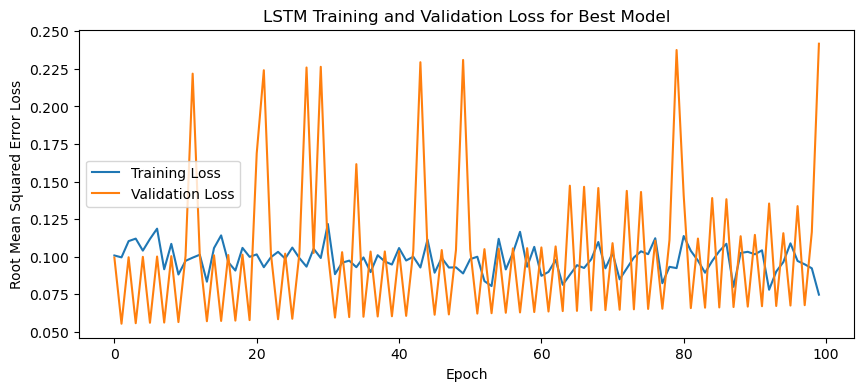

1/1 - 3s - loss: 0.1553 - 3s/epoch - 3s/step
Test Loss: 0.15532928705215454
Fold 2:
Epoch 1/100
19/19 [==============================] - 5s 61ms/step - loss: 0.1388 - val_loss: 0.0603
Epoch 2/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0989 - val_loss: 0.0763
Epoch 3/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0821 - val_loss: 0.0591
Epoch 4/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0861 - val_loss: 0.0769
Epoch 5/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0842 - val_loss: 0.0579
Epoch 6/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0851 - val_loss: 0.0781
Epoch 7/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0987 - val_loss: 0.0567
Epoch 8/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0908 - val_loss: 0.0794
Epoch 9/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0977 - val_loss: 0.0554
Epoch 10/100
19/19 [====

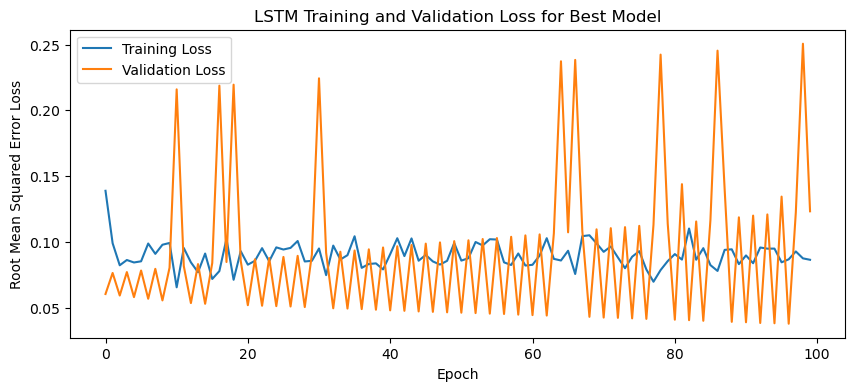

1/1 - 2s - loss: 0.0449 - 2s/epoch - 2s/step
Test Loss: 0.044888585805892944
Fold 3:
Epoch 1/100
19/19 [==============================] - 5s 60ms/step - loss: 0.4423 - val_loss: 0.1022
Epoch 2/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0845 - val_loss: 0.0673
Epoch 3/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0958 - val_loss: 0.1014
Epoch 4/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0737 - val_loss: 0.2334
Epoch 5/100
19/19 [==============================] - 0s 6ms/step - loss: 0.1046 - val_loss: 0.1008
Epoch 6/100
19/19 [==============================] - 0s 6ms/step - loss: 0.1061 - val_loss: 0.0676
Epoch 7/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1005 - val_loss: 0.0997
Epoch 8/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1067 - val_loss: 0.0678
Epoch 9/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1000 - val_loss: 0.0992
Epoch 10/100
19/19 [===

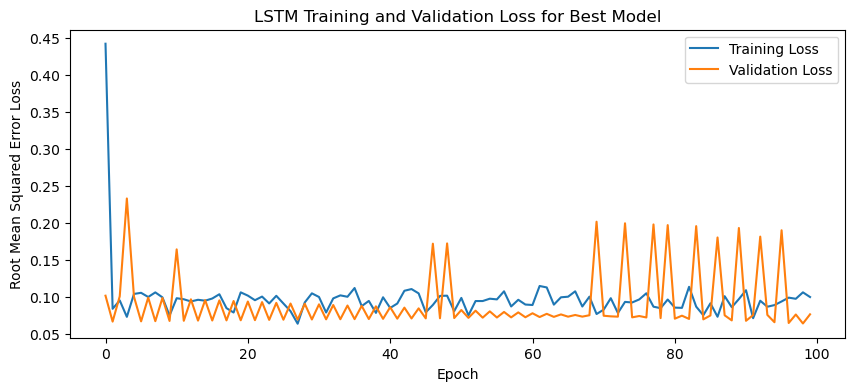

1/1 - 1s - loss: 0.0806 - 1s/epoch - 1s/step
Test Loss: 0.0805894285440445
Fold 4:
Epoch 1/100
20/20 [==============================] - 7s 132ms/step - loss: 0.2612 - val_loss: 0.1641
Epoch 2/100
20/20 [==============================] - 0s 9ms/step - loss: 0.0906 - val_loss: 0.1101
Epoch 3/100
20/20 [==============================] - 0s 8ms/step - loss: 0.1087 - val_loss: 0.1653
Epoch 4/100
20/20 [==============================] - 0s 8ms/step - loss: 0.0891 - val_loss: 0.1660
Epoch 5/100
20/20 [==============================] - 0s 9ms/step - loss: 0.0965 - val_loss: 0.1666
Epoch 6/100
20/20 [==============================] - 0s 8ms/step - loss: 0.0922 - val_loss: 0.1668
Epoch 7/100
20/20 [==============================] - 0s 10ms/step - loss: 0.0845 - val_loss: 0.1674
Epoch 8/100
20/20 [==============================] - 0s 9ms/step - loss: 0.0968 - val_loss: 0.1680
Epoch 9/100
20/20 [==============================] - 0s 8ms/step - loss: 0.0936 - val_loss: 0.1684
Epoch 10/100
20/20 [===

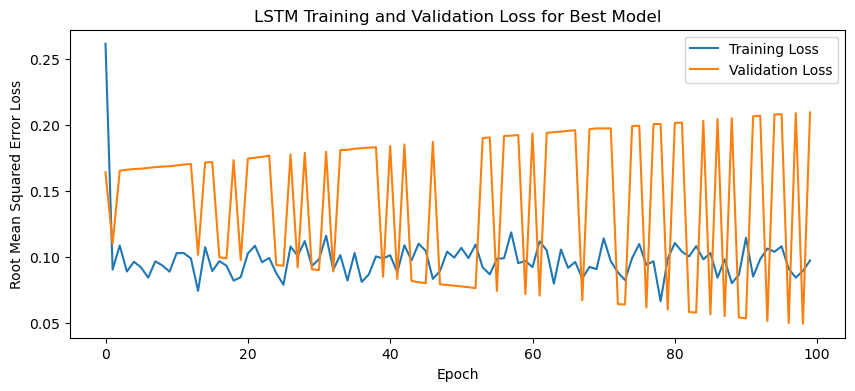

1/1 - 1s - loss: 0.1391 - 862ms/epoch - 862ms/step
Test Loss: 0.1390584111213684
Fold 5:
Epoch 1/100
19/19 [==============================] - 9s 71ms/step - loss: 0.1090 - val_loss: 0.2366
Epoch 2/100
19/19 [==============================] - 0s 6ms/step - loss: 0.1196 - val_loss: 0.1040
Epoch 3/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0864 - val_loss: 0.0285
Epoch 4/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0792 - val_loss: 0.1047
Epoch 5/100
19/19 [==============================] - 0s 6ms/step - loss: 0.1038 - val_loss: 0.0282
Epoch 6/100
19/19 [==============================] - 0s 8ms/step - loss: 0.0889 - val_loss: 0.1054
Epoch 7/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0951 - val_loss: 0.0280
Epoch 8/100
19/19 [==============================] - 0s 6ms/step - loss: 0.1007 - val_loss: 0.1059
Epoch 9/100
19/19 [==============================] - 0s 6ms/step - loss: 0.1087 - val_loss: 0.0278
Epoch 10/100
19/19 

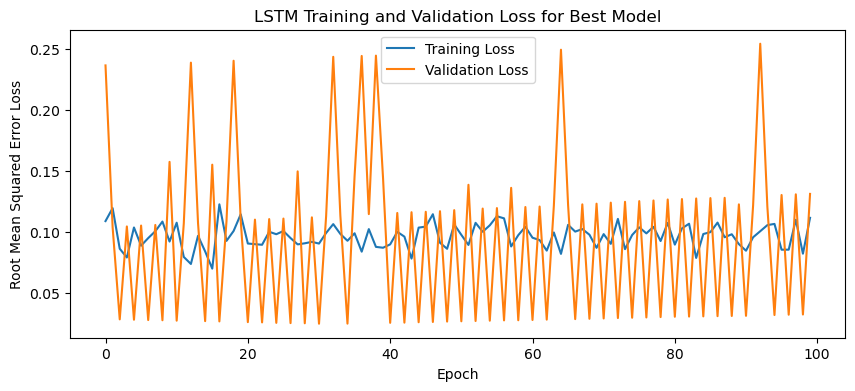

1/1 - 2s - loss: 0.0934 - 2s/epoch - 2s/step
Test Loss: 0.09337668865919113


In [3]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit an LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):

    cv_accuracies = []
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

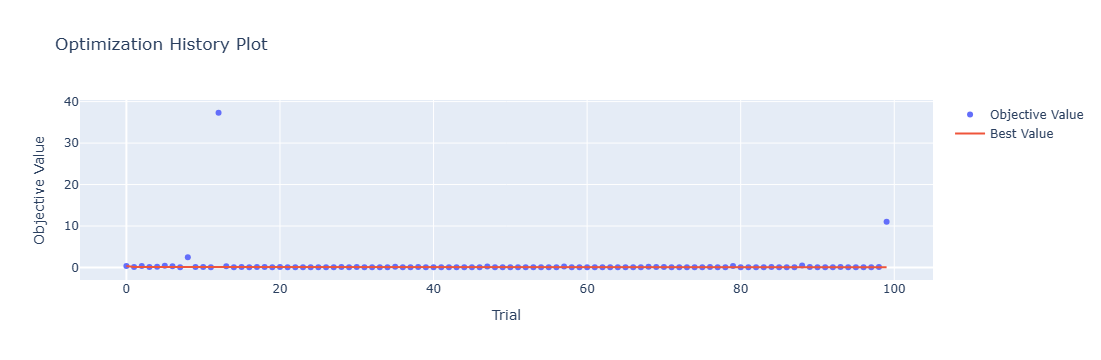

In [4]:
optuna.visualization.plot_optimization_history(study)

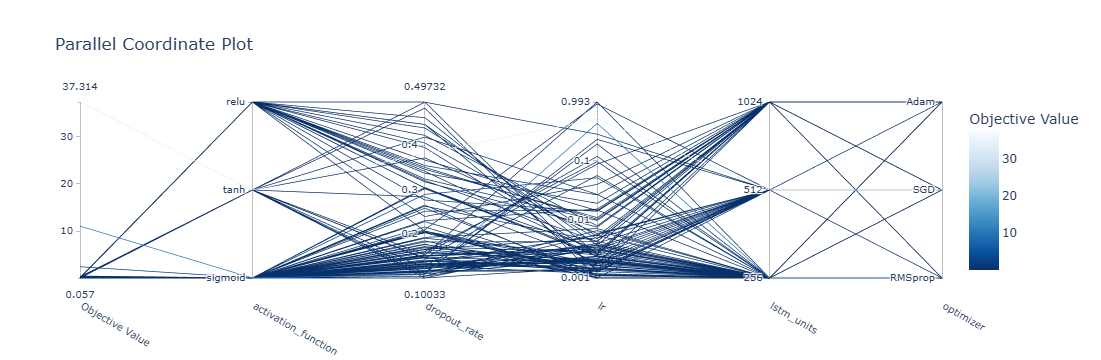

In [5]:
optuna.visualization.plot_parallel_coordinate(study)

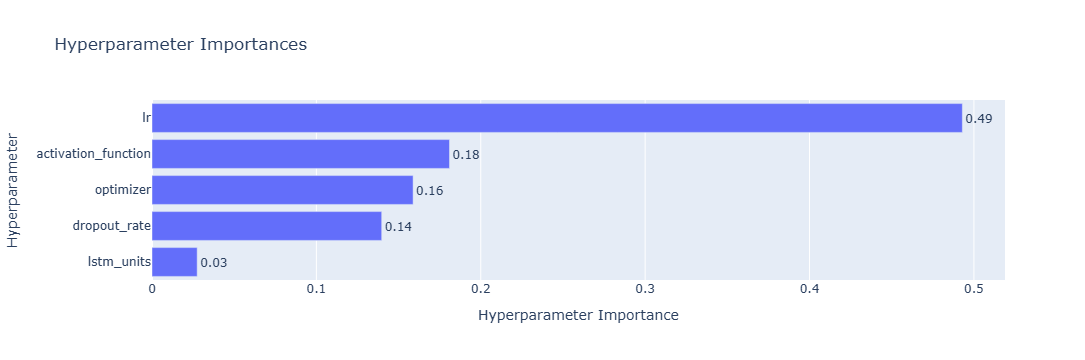

In [6]:
optuna.visualization.plot_param_importances(study)

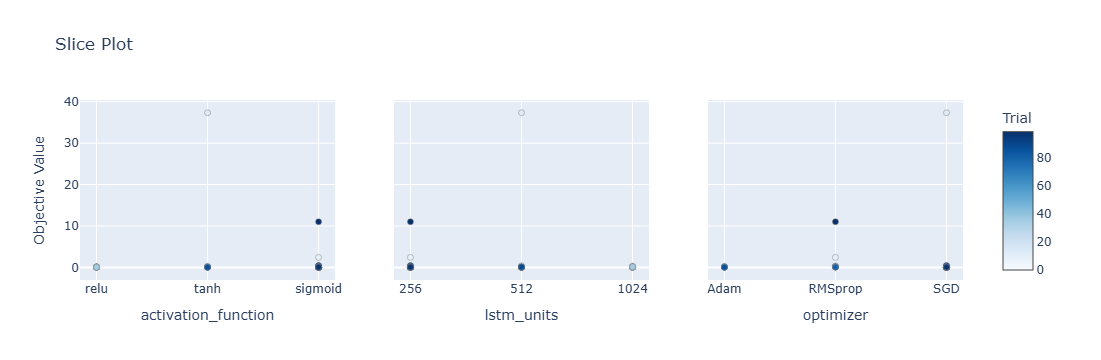

In [7]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

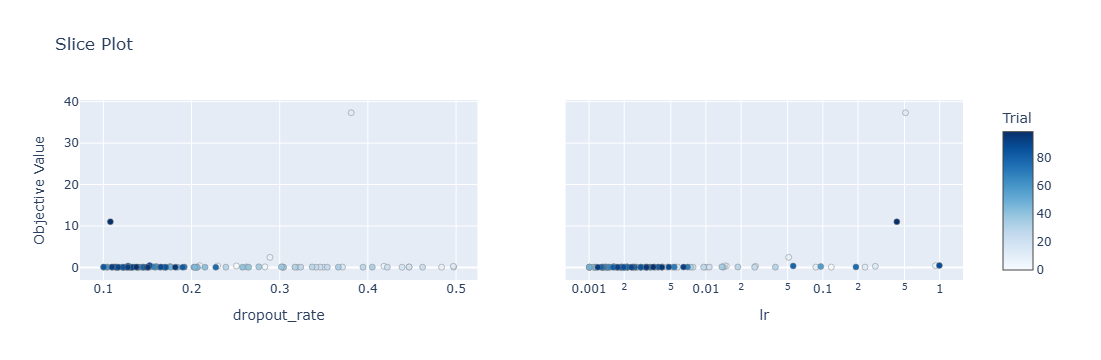

In [8]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate'])

[[20.84 20.69 20.47 20.3  20.46 20.31 20.43 20.63 21.05 20.79 20.3  20.47
  19.79 21.11 21.38 20.92 20.47 21.77 22.5  22.86 21.64 21.57 21.74 21.57
  21.81 22.23 22.62]
 [16.57 15.99 15.39 15.45 15.98 15.45 15.57 15.59 15.96 16.16 15.83 15.88
  15.64 16.44 17.   15.83 15.63 16.9  17.06 17.3  17.26 18.21 17.38 16.87
  17.15 16.98 18.47]]
Epoch 1/100
19/19 [==============================] - 6s 121ms/step - loss: 0.0955 - accuracy: 0.0000e+00 - mae: 0.0955 - rmse: 0.0955 - mape: 17.7847 - pearson: nan - val_loss: 0.1390 - val_accuracy: 0.0000e+00 - val_mae: 0.1390 - val_rmse: 0.1390 - val_mape: 22.2689 - val_pearson: nan
Epoch 2/100
19/19 [==============================] - 0s 9ms/step - loss: 0.1095 - accuracy: 0.0000e+00 - mae: 0.1095 - rmse: 0.1095 - mape: 19.4914 - pearson: nan - val_loss: 0.0753 - val_accuracy: 0.0000e+00 - val_mae: 0.0753 - val_rmse: 0.0753 - val_mape: 13.3046 - val_pearson: nan
Epoch 3/100
19/19 [==============================] - 0s 8ms/step - loss: 0.1015 - accurac

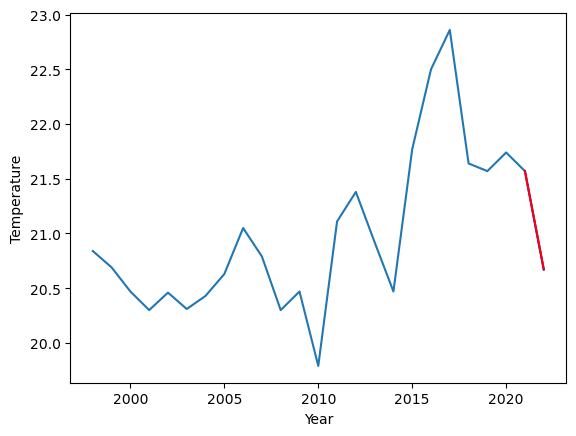

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
16.06		16.41		0.35


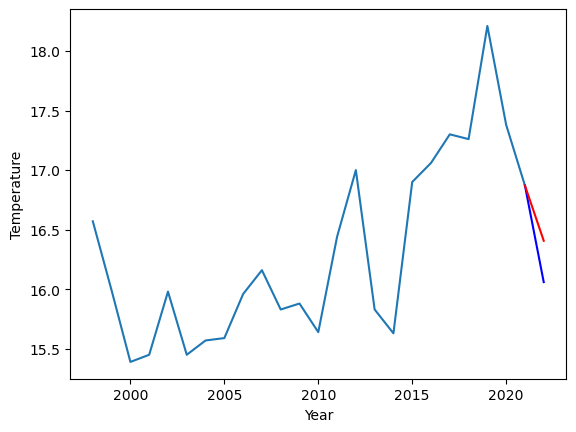

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   20.67  20.678001
1                1   16.06  16.407092


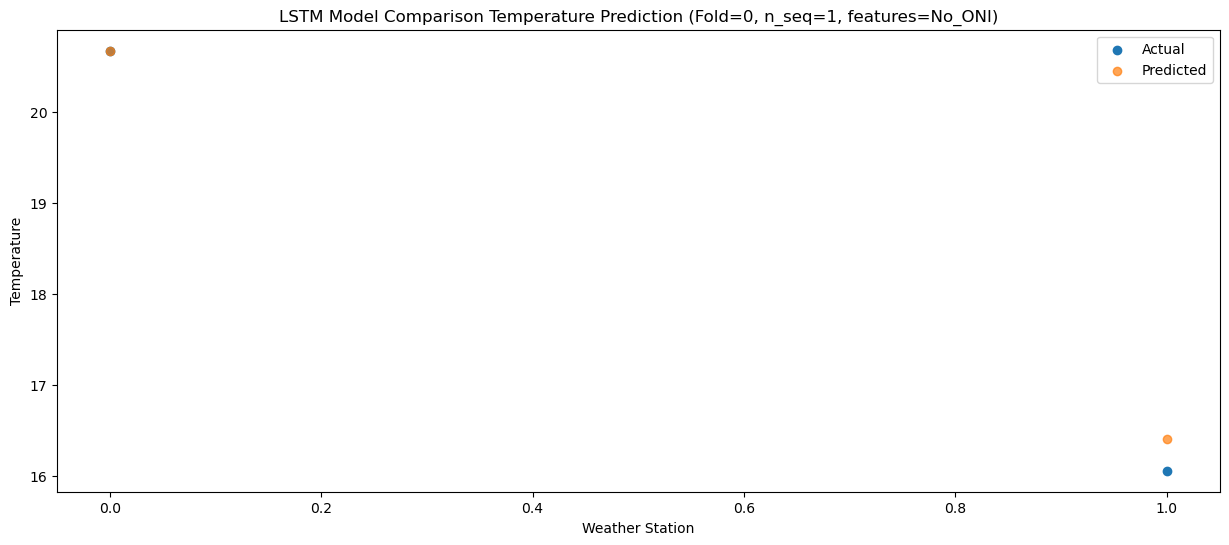

f, t:
[[20.67 16.06]]
[[20.67800109 16.40709204]]
Year at t+1:
t+1 SKRMSE: 0.245496
t+1 KRMSE: 0.245496
t+1 MAE: 0.177547
t+1 SKMAPE: 0.011000
t+1 R2_SCORE: 0.988656
t+1 KMAPE: 0.011000
t+1 PEARSON: 1.000000
Metrics for this Fold:
SKRMSE: 0.245496
KRMSE: 0.245496
MAE: 0.177547
SKMAPE: 0.011000
R2_SCORE: 0.988656
KMAPE: 0.011000
PEARSON: 1.000000
Model: "sequential_520"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1040 (LSTM)            (1, 1, 256)               510976    
                                                                 
 dropout_1040 (Dropout)      (1, 1, 256)               0         
                                                                 
 lstm_1041 (LSTM)            (1, 256)                  525312    
                                                                 
 dropout_1041 (Dropout)      (1, 256)                  0         
                                  

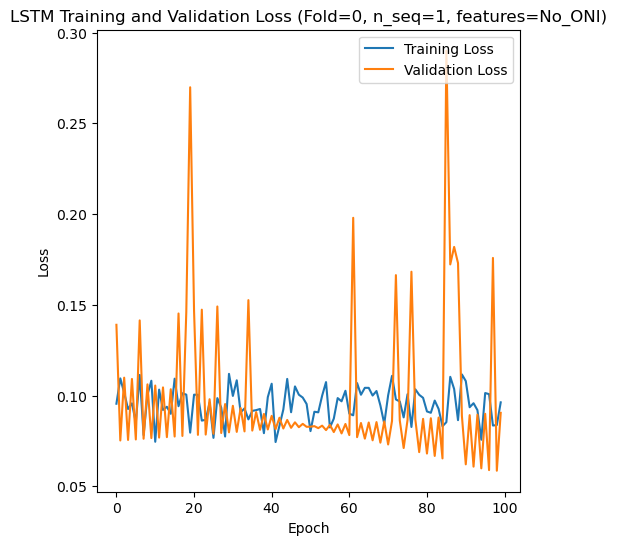

[[19.54 18.69 17.98 18.61 18.9  18.32 18.53 18.52 18.91 19.16 18.59 18.48
  18.2  19.26 19.25 18.86 18.95 19.48 19.77 19.73 19.56 19.64 19.73 18.81
  19.15 19.99 20.79]
 [19.69 19.59 19.68 19.6  19.14 19.33 18.41 19.15 20.48 18.58 19.32 19.44
  18.75 20.43 20.08 18.77 18.96 18.48 19.51 19.89 19.04 19.17 19.69 19.3
  19.3  20.61 21.9 ]]
Epoch 1/100
19/19 [==============================] - 5s 108ms/step - loss: 0.0999 - accuracy: 0.0000e+00 - mae: 0.0999 - rmse: 0.0999 - mape: 15.7303 - pearson: nan - val_loss: 0.0482 - val_accuracy: 0.0000e+00 - val_mae: 0.0482 - val_rmse: 0.0482 - val_mape: 7.5166 - val_pearson: nan
Epoch 2/100
19/19 [==============================] - 0s 11ms/step - loss: 0.0665 - accuracy: 0.0000e+00 - mae: 0.0665 - rmse: 0.0665 - mape: 10.5423 - pearson: nan - val_loss: 0.1631 - val_accuracy: 0.0000e+00 - val_mae: 0.1631 - val_rmse: 0.1631 - val_mape: 24.9436 - val_pearson: nan
Epoch 3/100
19/19 [==============================] - 0s 9ms/step - loss: 0.0762 - accuracy

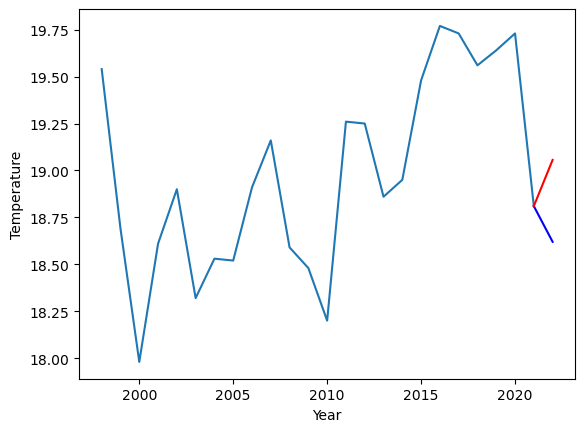

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
19.30		19.21		-0.09


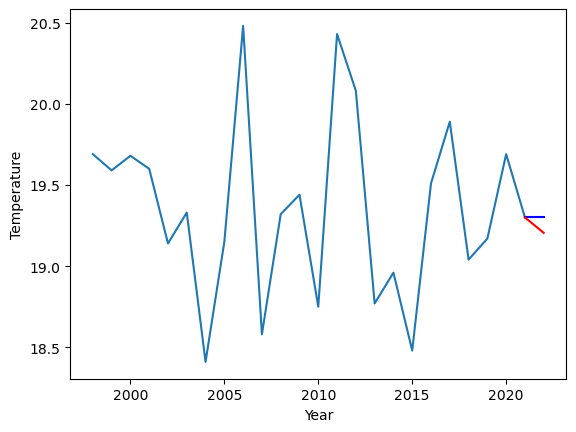

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   18.62  19.056120
1                1   19.30  19.205189


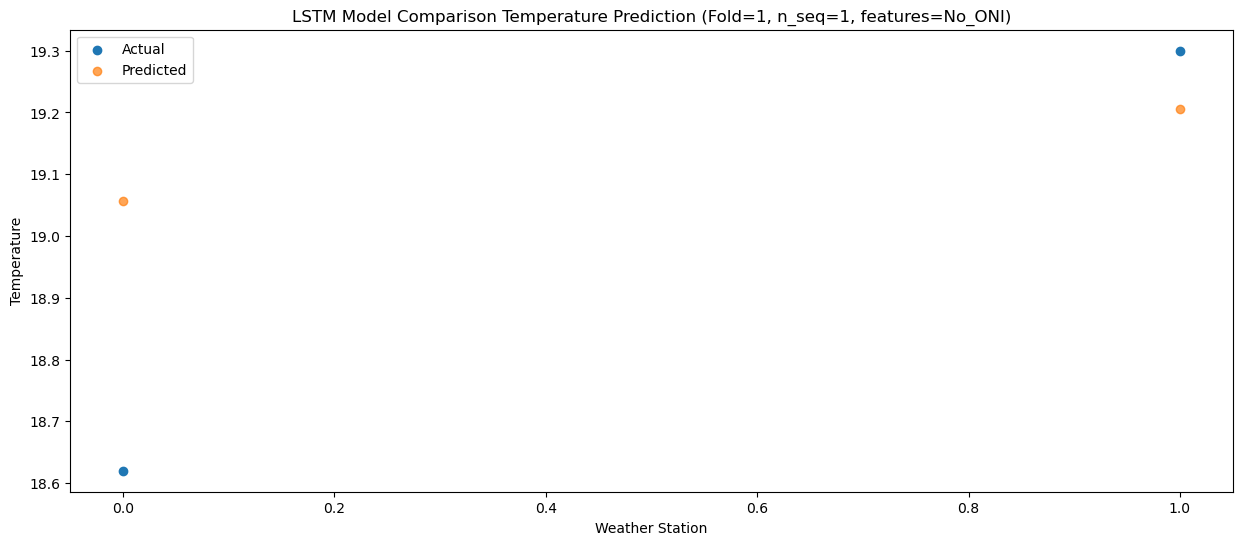

f, t:
[[18.62 19.3 ]]
[[19.05611963 19.20518893]]
Year at t+1:
t+1 SKRMSE: 0.315586
t+1 KRMSE: 0.315586
t+1 MAE: 0.265465
t+1 SKMAPE: 0.014167
t+1 R2_SCORE: 0.138454
t+1 KMAPE: 0.014167
t+1 PEARSON: 1.000000
Metrics for this Fold:
SKRMSE: 0.315586
KRMSE: 0.315586
MAE: 0.265465
SKMAPE: 0.014167
R2_SCORE: 0.138454
KMAPE: 0.014167
PEARSON: 1.000000
Model: "sequential_521"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1042 (LSTM)            (1, 1, 256)               510976    
                                                                 
 dropout_1042 (Dropout)      (1, 1, 256)               0         
                                                                 
 lstm_1043 (LSTM)            (1, 256)                  525312    
                                                                 
 dropout_1043 (Dropout)      (1, 256)                  0         
                                  

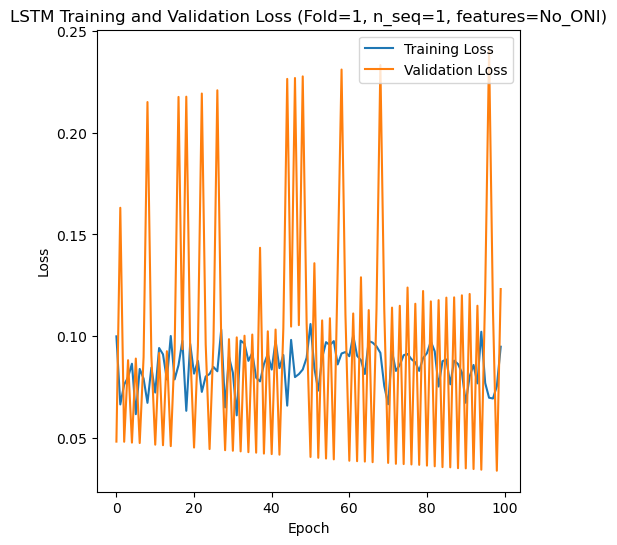

[[16.84 16.42 15.63 15.84 16.01 15.21 15.86 15.86 16.6  17.15 15.61 15.43
  15.69 16.61 16.97 15.29 15.43 16.62 17.18 16.96 16.33 17.09 16.39 16.63
  16.6  17.04 18.25]
 [13.51 12.74 11.83 12.67 12.83 11.71 12.25 12.85 13.05 13.49 12.15 12.07
  12.6  13.05 14.02 12.15 11.53 12.87 13.64 13.46 12.99 13.32 13.31 13.3
  12.84 13.63 15.32]]
Epoch 1/100
19/19 [==============================] - 6s 77ms/step - loss: 0.3525 - accuracy: 0.0000e+00 - mae: 0.3525 - rmse: 0.3525 - mape: 56.0588 - pearson: nan - val_loss: 0.1537 - val_accuracy: 0.0000e+00 - val_mae: 0.1537 - val_rmse: 0.1537 - val_mape: 24.3955 - val_pearson: nan
Epoch 2/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1002 - accuracy: 0.0000e+00 - mae: 0.1002 - rmse: 0.1002 - mape: 16.0696 - pearson: nan - val_loss: 0.0611 - val_accuracy: 0.0000e+00 - val_mae: 0.0611 - val_rmse: 0.0611 - val_mape: 10.2824 - val_pearson: nan
Epoch 3/100
19/19 [==============================] - 0s 8ms/step - loss: 0.0944 - accuracy:

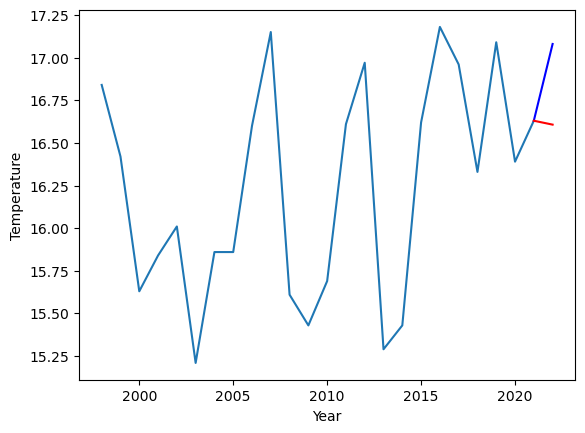

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.50		13.28		-0.22


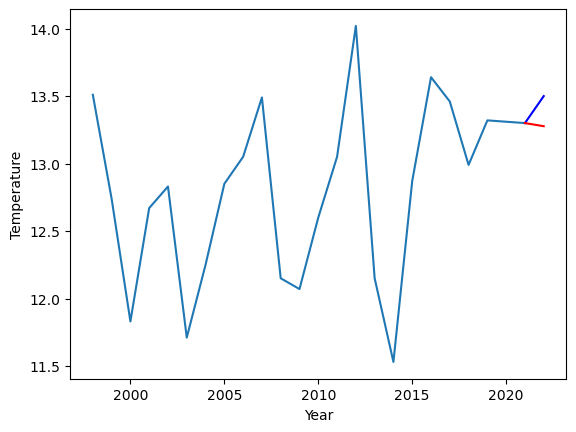

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   17.08  16.607122
1                1   13.50  13.276849


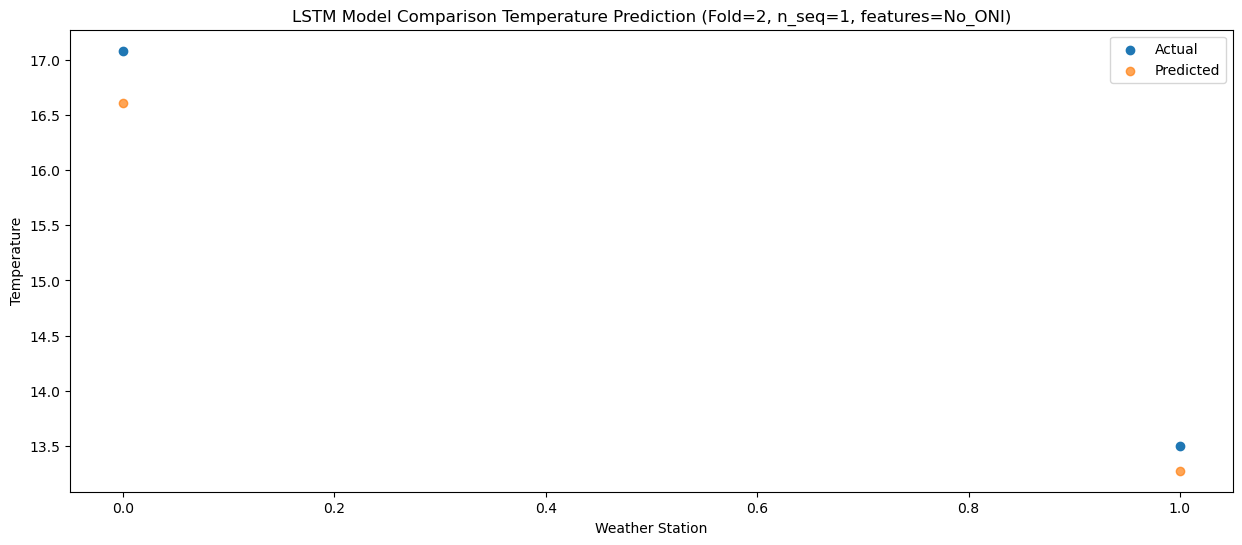

f, t:
[[17.08 13.5 ]]
[[16.60712215 13.2768494 ]]
Year at t+1:
t+1 SKRMSE: 0.369736
t+1 KRMSE: 0.369736
t+1 MAE: 0.348014
t+1 SKMAPE: 0.022108
t+1 R2_SCORE: 0.957334
t+1 KMAPE: 0.022108
t+1 PEARSON: 1.000000
Metrics for this Fold:
SKRMSE: 0.369736
KRMSE: 0.369736
MAE: 0.348014
SKMAPE: 0.022108
R2_SCORE: 0.957334
KMAPE: 0.022108
PEARSON: 1.000000
Model: "sequential_522"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1044 (LSTM)            (1, 1, 256)               510976    
                                                                 
 dropout_1044 (Dropout)      (1, 1, 256)               0         
                                                                 
 lstm_1045 (LSTM)            (1, 256)                  525312    
                                                                 
 dropout_1045 (Dropout)      (1, 256)                  0         
                                  

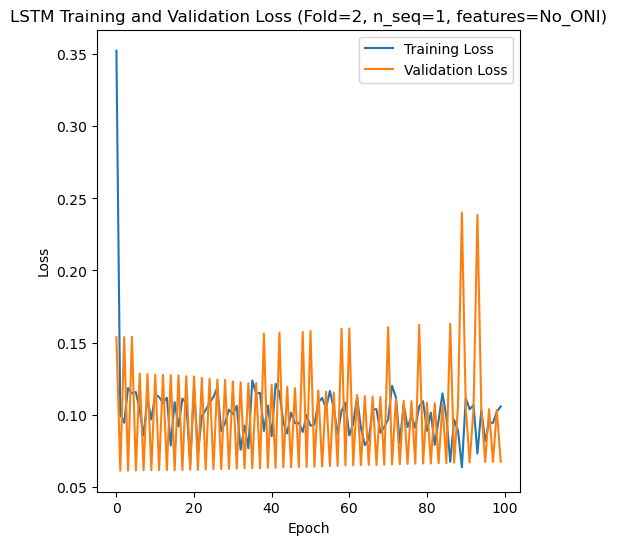

[[14.79 16.53 17.4  17.93 17.46 17.79 17.15 17.27 16.83 16.99 17.41 16.9
  16.66 16.28 17.66 17.63 19.01 18.49 18.19 18.12 18.2  17.83 17.88 18.2
  18.19 17.9  20.04]
 [14.06 13.64 12.62 13.34 13.58 12.56 13.34 13.7  13.71 13.89 12.74 12.51
  12.94 13.34 14.11 12.94 11.91 13.01 14.3  14.13 13.64 14.05 13.93 13.73
  13.43 14.45 16.49]]
Epoch 1/100
20/20 [==============================] - 22s 289ms/step - loss: 0.1077 - accuracy: 0.0000e+00 - mae: 0.1077 - rmse: 0.1077 - mape: 17.5921 - pearson: nan - val_loss: 0.0300 - val_accuracy: 0.0000e+00 - val_mae: 0.0300 - val_rmse: 0.0300 - val_mape: 4.1305 - val_pearson: nan
Epoch 2/100
20/20 [==============================] - 0s 18ms/step - loss: 0.0842 - accuracy: 0.0000e+00 - mae: 0.0842 - rmse: 0.0842 - mape: 13.6093 - pearson: nan - val_loss: 0.0304 - val_accuracy: 0.0000e+00 - val_mae: 0.0304 - val_rmse: 0.0304 - val_mape: 4.1856 - val_pearson: nan
Epoch 3/100
20/20 [==============================] - 0s 23ms/step - loss: 0.0990 - accuracy

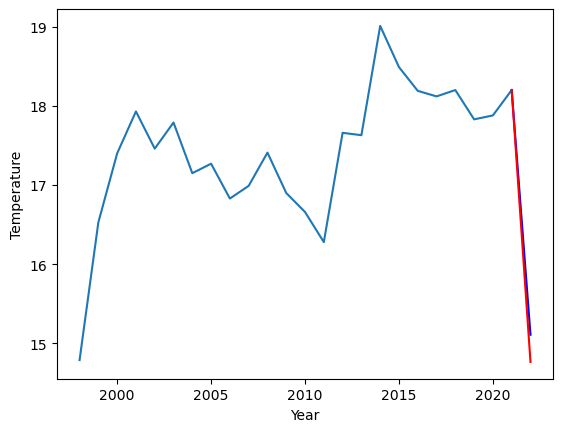

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.86		14.04		0.18


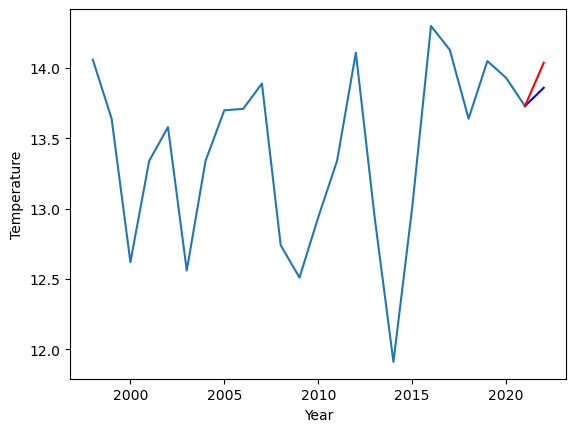

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   15.11  14.766571
1                1   13.86  14.037916


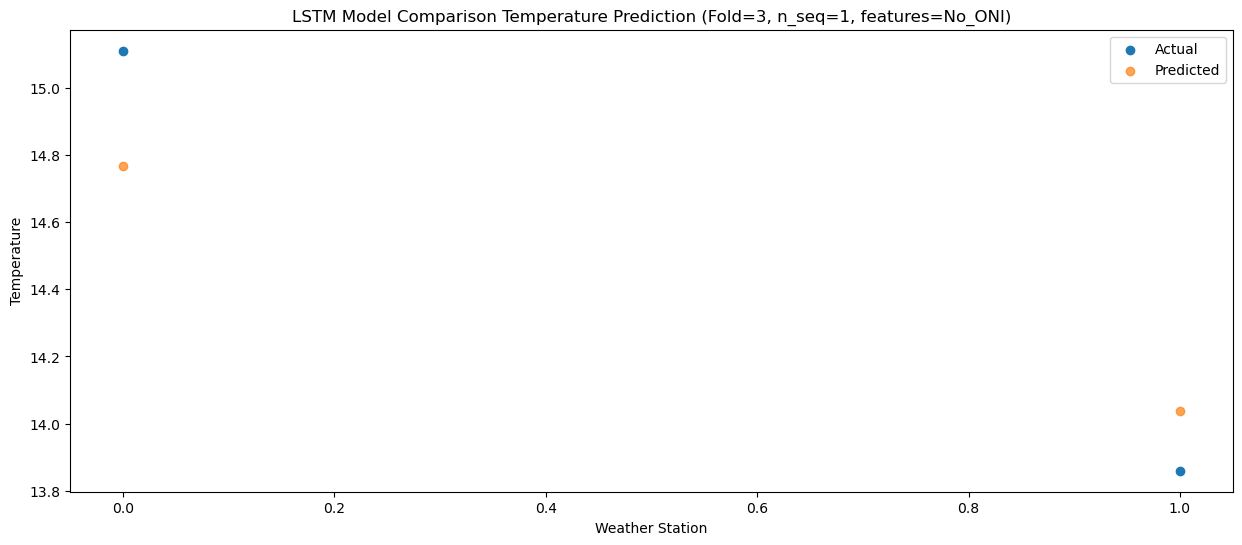

f, t:
[[15.11 13.86]]
[[14.76657126 14.03791609]]
Year at t+1:
t+1 SKRMSE: 0.273494
t+1 KRMSE: 0.273494
t+1 MAE: 0.260672
t+1 SKMAPE: 0.017783
t+1 R2_SCORE: 0.808515
t+1 KMAPE: 0.017783
t+1 PEARSON: 1.000000
Metrics for this Fold:
SKRMSE: 0.273494
KRMSE: 0.273494
MAE: 0.260672
SKMAPE: 0.017783
R2_SCORE: 0.808515
KMAPE: 0.017783
PEARSON: 1.000000
Model: "sequential_523"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1046 (LSTM)            (1, 1, 256)               510976    
                                                                 
 dropout_1046 (Dropout)      (1, 1, 256)               0         
                                                                 
 lstm_1047 (LSTM)            (1, 256)                  525312    
                                                                 
 dropout_1047 (Dropout)      (1, 256)                  0         
                                  

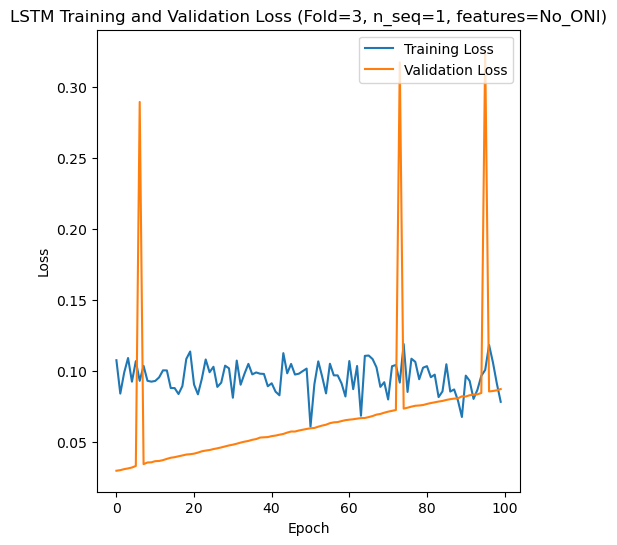

[[21.14 18.96 18.26 17.93 17.59 18.09 18.   18.94 19.77 18.17 18.51 17.84
  17.96 19.05 19.41 17.5  17.5  18.37 18.89 19.09 18.25 18.12 18.64 18.22
  18.72 19.65 20.58]
 [12.93 12.18 11.5  12.1  11.94 11.27 11.81 12.49 12.65 12.57 10.89 11.63
  12.44 12.56 14.1  11.08 10.78 12.73 13.75 13.68 12.38 11.68 12.24 12.56
  11.69 13.17 14.51]]
Epoch 1/100
19/19 [==============================] - 17s 302ms/step - loss: 0.1914 - accuracy: 0.0000e+00 - mae: 0.1914 - rmse: 0.1914 - mape: 30.3578 - pearson: nan - val_loss: 0.1826 - val_accuracy: 0.0000e+00 - val_mae: 0.1826 - val_rmse: 0.1826 - val_mape: 27.5205 - val_pearson: nan
Epoch 2/100
19/19 [==============================] - 1s 43ms/step - loss: 0.1066 - accuracy: 0.0000e+00 - mae: 0.1066 - rmse: 0.1066 - mape: 17.0663 - pearson: nan - val_loss: 0.0492 - val_accuracy: 0.0000e+00 - val_mae: 0.0492 - val_rmse: 0.0492 - val_mape: 7.2321 - val_pearson: nan
Epoch 3/100
19/19 [==============================] - 1s 38ms/step - loss: 0.0953 - accur

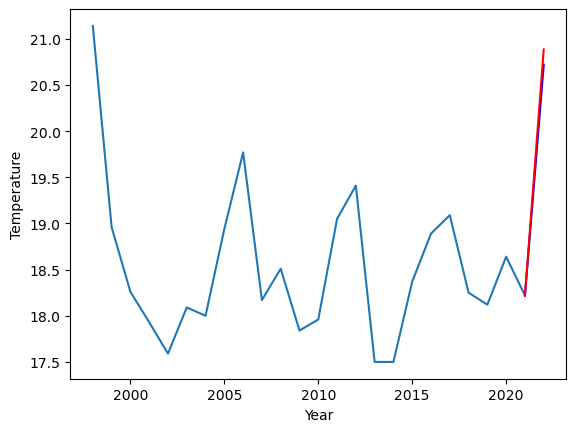

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.25		12.68		-0.57


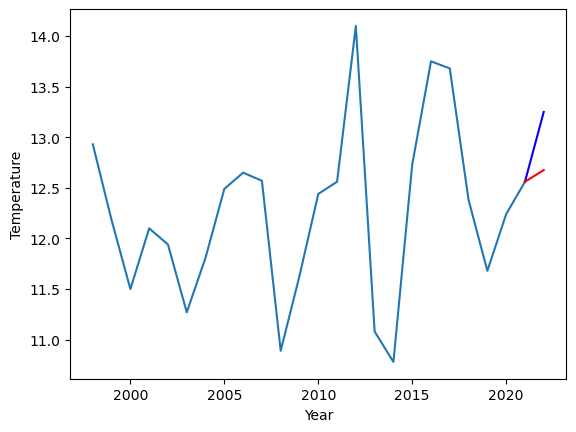

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   20.72  20.885166
1                1   13.25  12.676056


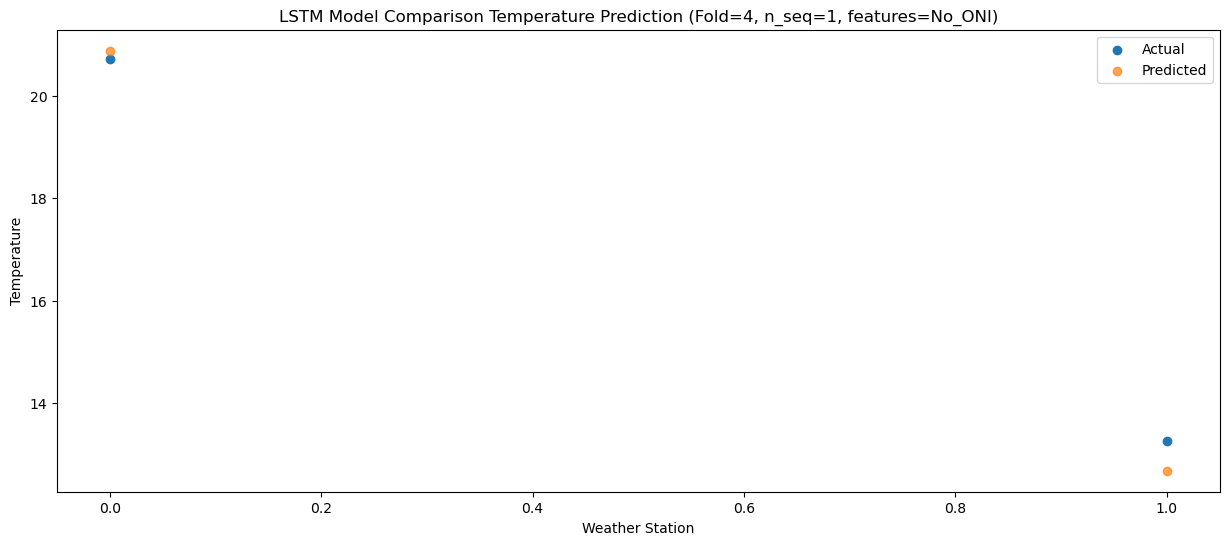

f, t:
[[20.72 13.25]]
[[20.88516612 12.67605572]]
Year at t+1:
t+1 SKRMSE: 0.422310
t+1 KRMSE: 0.422310
t+1 MAE: 0.369555
t+1 SKMAPE: 0.025644
t+1 R2_SCORE: 0.987216
t+1 KMAPE: 0.025644
t+1 PEARSON: 1.000000
Metrics for this Fold:
SKRMSE: 0.422310
KRMSE: 0.422310
MAE: 0.369555
SKMAPE: 0.025644
R2_SCORE: 0.987216
KMAPE: 0.025644
PEARSON: 1.000000
Model: "sequential_524"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1048 (LSTM)            (1, 1, 256)               510976    
                                                                 
 dropout_1048 (Dropout)      (1, 1, 256)               0         
                                                                 
 lstm_1049 (LSTM)            (1, 256)                  525312    
                                                                 
 dropout_1049 (Dropout)      (1, 256)                  0         
                                  

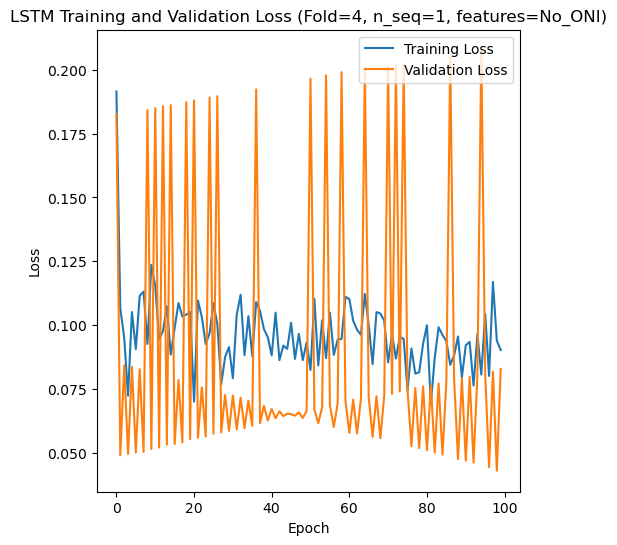

[[0.24549633703634516], [0.3155863348286544], [0.36973615756621403], [0.27349353853309616], [0.4223102426744732]]
[[array(0.24549634)], [array(0.31558633)], [array(0.36973616)], [array(0.27349354)], [array(0.42231024)]]
[[0.17754656463861274], [0.26546534836292324], [0.34801422595977716], [0.26067241210490444], [0.36955520033836464]]
[[0.010999646899945687], [0.014167298688320038], [0.022107865499782137], [0.017782615732564358], [0.02564394362180195]]
[[0.9886564713137501], [0.13845385181156944], [0.9573344070997072], [0.8085152880144528], [0.9872155509271161]]
[[array(0.01099965)], [array(0.0141673)], [array(0.02210787)], [array(0.01778262)], [array(0.02564394)]]
[[array(1.)], [array(1.)], [array(1.)], [array(1.)], [array(1.)]]
[20.67 16.06 18.62 19.3  17.08 13.5  15.11 13.86 20.72 13.25]
[20.67800109 16.40709204 19.05611963 19.20518893 16.60712215 13.2768494
 14.76657126 14.03791609 20.88516612 12.67605572]
Accuracy Results:
RMSE for each fold:
[[0.24549633703634516], [0.315586334828

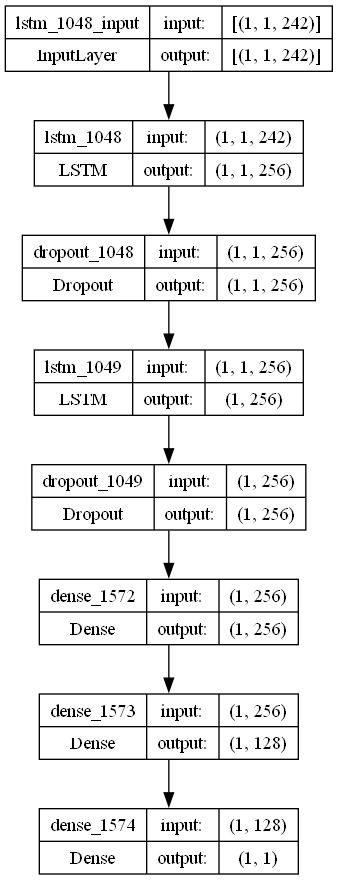

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def kmape (y_true, y_pred):
    return K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def kpearson (y_true, y_pred):
    mean_true = K.mean(y_true)
    mean_pred = K.mean(y_pred)
    return (K.square(K.mean((y_true - mean_true)*(y_pred - mean_pred))))/(K.mean(K.square(y_true - mean_true))*K.mean(K.square(y_pred - mean_pred)))

# fit the best LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    lr = 0.003123976759506953
    optimizer = SGD(learning_rate = lr)
    activation_function = 'sigmoid'
    lstm_units = 256
    dropout_rate = 0.1492253500061234

    # design network
    model = Sequential()
    #model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# make one forecast with an LSTM,
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_lstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_lstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# Evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(actual, forecasts, n_lag, n_seq):

    t = np.array(actual).transpose()
    f = np.array(forecasts).transpose()

    print("f, t:")
    print(t)
    print(f)
    rmse_list = []
    mae_list = []
    skmape_list = []
    mape_list = []
    r2_list = []
    pearson_list = []

    for i in range(n_seq):
        act = [row for row in t[i]]
        predicted = [forecast for forecast in f[i]]
        rmse1 = sqrt(mean_squared_error(act, predicted))
        rmse2 = np.array(rmse(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        mae = mean_absolute_error(act, predicted)
        mse = mean_squared_error(act, predicted)
        skmape = mean_absolute_percentage_error(act, predicted)
        kmape1 = np.array(kmape(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        kpearson1 = np.array(kpearson(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        r2 = r2_score(act, predicted) 
        print("Year at t+"+str(i+1)+":")
        print('t+%d SKRMSE: %f' % ((i+1), rmse1))
        print('t+%d KRMSE: %f' % ((i+1), rmse2))        
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d SKMAPE: %f' % ((i+1), skmape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))
        print('t+%d KMAPE: %f' % ((i+1), kmape1))
        print('t+%d PEARSON: %f' % ((i+1), kpearson1))

    y_true = tf.convert_to_tensor(np.array(actual).flatten())
    y_pred = tf.convert_to_tensor(np.array(forecasts).flatten())

    rmse1 = sqrt(mean_squared_error(np.array(y_true), np.array(y_pred)))
    rmse2 = np.array(rmse(y_true, y_pred))
    mae = mean_absolute_error(np.array(y_true), np.array(y_pred))
    mse = mean_squared_error(np.array(y_true), np.array(y_pred))
    skmape = mean_absolute_percentage_error(np.array(y_true), np.array(y_pred))
    kmape1 = np.array(kmape(y_true, y_pred))
    kpearson1 = np.array(kpearson(y_true, y_pred))
    r2 = r2_score(np.array(y_true), np.array(y_pred)) 
    rmse1_list.append(rmse1)
    rmse2_list.append(rmse2)
    mae_list.append(mae)
    skmape_list.append(skmape)
    pearson_list.append(kpearson1)
    mape_list.append(kmape1)
    r2_list.append(r2)
    print("Metrics for this Fold:")
    print('SKRMSE: %f' % (rmse1))
    print('KRMSE: %f' % (rmse2))        
    print('MAE: %f' % (mae))
    print('SKMAPE: %f' % (skmape))
    print('R2_SCORE: %f' % (r2))
    print('KMAPE: %f' % (kmape1))
    print('PEARSON: %f' % (kpearson1))

    return rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list
     
# Plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, actual, n_test, n_seq, n_lag):
    # Plot the actual data in blue
    plt.plot(series[:n_lag+2].index, series[:n_lag+2].values)
    off_s = n_lag + 1
    off_e = off_s + len(actual) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + actual
    plt.plot(xaxis, yaxis, color='blue')
    # Plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Year")
    plt.ylabel("Temperature")
    # show the plot
    plt.show()

n_batch = 1
n_test = 2
nb_epoch = 100
    
rmse1_avg_list = []
rmse2_avg_list = []
mae_avg_list = []
skmape_avg_list = []
r2_score_avg_list = []
mape_avg_list = []
pearson_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]
    
    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:2, :]
    dataset = dataset_df.values

    print(dataset)

    series = pd.Series(dataset[:, 0]) # Using first column (temperatures)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test, n_seq)

    # Print out plots of actual and predicted values for weather stations
    ws = [1,2]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    print(results_df)
    
    print("Actual and Forecasts:")
    print(actual)
    print(forecasts)
    
    for j in range(2):
        print("Weather Station "+str(j+1)+":")
        print("Actual Temp\tPredicted Temp\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:2, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (temperatures)
        forecasts_ws = forecasts[j]
        actual_ws = actual[j]

        # Set index starting from 1998
        series_ws.index = range(1998, 1998 + len(series_ws))        
        
        plot_forecasts(series_ws, forecasts_ws, actual_ws, n_test, n_seq, n_lag)

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(2):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)

        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='LSTM Model Comparison Temperature Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_ONI)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Temperature')
        plt.legend()
        plt.show()
    
    rmse1_list = [] # list stores sklearn's root mean squared errors for each future time prediction
    rmse2_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores mean absolute errors for each future time prediction
    skmape_list = [] # list stores sklearn's mean squared percentage errors for each future time prediction
    r2_list = [] # list stores sklearn's r2 pearson values for each future time prediction
    mape_list = [] # list stores mean squared percentage errors for each future time prediction
    pearson_list = [] # list stores r2 pearson values for each future time prediction

    # evaluate forecasts
    rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse1_avg_list.append(rmse1_list)
    rmse2_avg_list.append(rmse2_list)
    mae_avg_list.append(mae_list)
    skmape_avg_list.append(skmape_list)
    r2_score_avg_list.append(r2_list)
    mape_avg_list.append(mape_list)
    pearson_avg_list.append(pearson_list)                        
    forecast_results.append(forecasts)
    actual_results.append(actual)
            
    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_ONI)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse1_avg_list)
print(rmse2_avg_list)
print(mae_avg_list)
print(skmape_avg_list)
print(r2_score_avg_list)
print(mape_avg_list)
print(pearson_avg_list)
print(np.array(actual_results).flatten())
print(np.array(forecast_results).flatten())
a2 = np.array(actual_results).flatten()
f2 = np.array(forecast_results).flatten()
p1 = np.array(pearson(tf.convert_to_tensor(a2), tf.convert_to_tensor(f2)))
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse1_avg_list)
print("Average SKRMSE:"+str(np.mean(rmse1_avg_list)))
print("Average KRMSE:"+str(np.mean(rmse2_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average SKMAPE:"+str(np.mean(skmape_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average PEARSON:"+str(p1))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))

# Plot model architecture
filename = "lstm_model_optimized_CV_S1_No_ONI.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)